In [11]:
import operator
import warnings
from typing import *
import traceback

import os
import torch
from dotenv import load_dotenv
from IPython.display import Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from transformers import logging
import matplotlib.pyplot as plt
import numpy as np
import json
from medrax.agent import *
from medrax.tools import *
from medrax.utils import *

warnings.filterwarnings("ignore")
logging.set_verbosity_error()
_ = load_dotenv()

PROMPT_FILE = "medrax/docs/system_prompts.txt"
BENCHMARK_FILE = "benchmark/questions"
MODEL_DIR = "/model-weights"

"""
medsam
    chexagent + med-llava
    fix enviornments
make medrax prompts better
write loop to go through benchmark
add gpt-4o vision

---

1. SFT or example database, prompt enhancing to make tool call better
2. show segmentation result overlay on the image
3. use ppx instead of cm2, support dicom
4. look agent benchmark + build benchmark

1. Login to huggingface
2. Setting up the cache download path
3. Some tools need extrenal download, hugging face authorization etc

1. Use biomedparse for segmentation
"""

'\nmedsam\n    chexagent + med-llava\n    fix enviornments\nmake medrax prompts better\nwrite loop to go through benchmark\nadd gpt-4o vision\n\n---\n\n1. SFT or example database, prompt enhancing to make tool call better\n2. show segmentation result overlay on the image\n3. use ppx instead of cm2, support dicom\n4. look agent benchmark + build benchmark\n\n1. Login to huggingface\n2. Setting up the cache download path\n3. Some tools need extrenal download, hugging face authorization etc\n\n1. Use biomedparse for segmentation\n'

In [12]:
# !pip install -U git+https://github.com/huggingface/transformers.git@88d960937c81a32bfb63356a2e8ecf7999619681
# !pip install transformers==4.40.0

In [27]:
from typing import Dict, List, Optional, Tuple, Type, Any
from pathlib import Path
import uuid
import tempfile

import numpy as np
import torch
import torchvision
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import skimage.io
import skimage.measure
import skimage.transform
import traceback

from pydantic import BaseModel, Field
from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool


class ChestXRaySegmentationInput(BaseModel):
    """Input schema for the Chest X-ray Segmentation Tool."""
    image_path: str = Field(..., description="Path to the chest X-ray image file to be segmented")
    organs: Optional[List[str]] = Field(
        None,
        description="List of organs to segment. If None, all available organs will be segmented. "
        "Available organs: Left/Right Clavicle, Left/Right Scapula, Left/Right Lung, "
        "Left/Right Hilus Pulmonis, Heart, Aorta, Facies Diaphragmatica, "
        "Mediastinum, Weasand, Spine",
    )


class OrganMetrics(BaseModel):
    """Detailed metrics for a segmented organ."""
    # Basic metrics
    area_pixels: int = Field(..., description="Area in pixels")
    area_cm2: float = Field(..., description="Approximate area in cm²")
    centroid: Tuple[float, float] = Field(..., description="(y, x) coordinates of centroid")
    bbox: Tuple[int, int, int, int] = Field(
        ..., description="Bounding box coordinates (min_y, min_x, max_y, max_x)"
    )

    # Size metrics
    width: int = Field(..., description="Width of the organ in pixels")
    height: int = Field(..., description="Height of the organ in pixels")
    aspect_ratio: float = Field(..., description="Height/width ratio")

    # Position metrics
    relative_position: Dict[str, float] = Field(
        ..., description="Position relative to image boundaries (0-1 scale)"
    )

    # Analysis metrics
    mean_intensity: float = Field(..., description="Mean pixel intensity in the organ region")
    std_intensity: float = Field(..., description="Standard deviation of pixel intensity")
    confidence_score: float = Field(..., description="Model confidence score for this organ")


class ChestXRaySegmentationTool(BaseTool):
    """Tool for performing detailed segmentation analysis of chest X-ray images."""
    name: str = "chest_xray_segmentation"
    description: str = (
        "Segments chest X-ray images to specified anatomical structures. "
        "Available organs: Left/Right Clavicle (collar bones), Left/Right Scapula (shoulder blades), "
        "Left/Right Lung, Left/Right Hilus Pulmonis (lung roots), Heart, Aorta, "
        "Facies Diaphragmatica (diaphragm), Mediastinum (central cavity), Weasand (esophagus), "
        "and Spine. Returns segmentation visualization and comprehensive metrics. "
        "Let the user know the area is not accurate unless input has been DICOM."
    )
    args_schema: Type[BaseModel] = ChestXRaySegmentationInput

    model: Any = None
    device: Optional[str] = "cuda"
    transform: Any = None
    pixel_spacing_mm: float = 0.2
    temp_dir: Path = Path("temp")
    organ_map: Dict[str, int] = None

    def __init__(self, device: Optional[str] = "cuda", temp_dir: Optional[Path] = Path("temp")):
        """Initialize the segmentation tool with model and temporary directory."""
        super().__init__()
        self.model = xrv.baseline_models.chestx_det.PSPNet()
        self.device = torch.device(device) if device else "cuda"
        self.model = self.model.to(self.device)
        self.model.eval()

        self.transform = torchvision.transforms.Compose(
            [xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(512)]
        )

        self.temp_dir = temp_dir if isinstance(temp_dir, Path) else Path(temp_dir)
        self.temp_dir.mkdir(exist_ok=True)

        # Map friendly names to model target indices
        self.organ_map = {
            "Left Clavicle": 0,
            "Right Clavicle": 1,
            "Left Scapula": 2,
            "Right Scapula": 3,
            "Left Lung": 4,
            "Right Lung": 5,
            "Left Hilus Pulmonis": 6,
            "Right Hilus Pulmonis": 7,
            "Heart": 8,
            "Aorta": 9,
            "Facies Diaphragmatica": 10,
            "Mediastinum": 11,
            "Weasand": 12,
            "Spine": 13,
        }

    def _align_mask_to_original(self, mask: np.ndarray, original_shape: Tuple[int, int]) -> np.ndarray:
        """
        Align a mask from the transformed (cropped/resized) space back to the full original image.
        Assumes that the transform does a center crop to a square of side = min(original height, width)
        and then resizes to (512,512).
        """
        orig_h, orig_w = original_shape
        crop_size = min(orig_h, orig_w)
        crop_top = (orig_h - crop_size) // 2
        crop_left = (orig_w - crop_size) // 2

        # Resize mask (from 512x512) to the cropped region size
        resized_mask = skimage.transform.resize(
            mask, (crop_size, crop_size), order=0, preserve_range=True, anti_aliasing=False
        )
        full_mask = np.zeros(original_shape)
        full_mask[crop_top:crop_top+crop_size, crop_left:crop_left+crop_size] = resized_mask
        return full_mask

    def _compute_organ_metrics(
        self, mask: np.ndarray, original_img: np.ndarray, confidence: float
    ) -> Optional[OrganMetrics]:
        """Compute comprehensive metrics for a single organ mask."""
        # Align mask to the original image coordinates if needed
        if mask.shape != original_img.shape:
            mask = self._align_mask_to_original(mask, original_img.shape)

        props = skimage.measure.regionprops(mask.astype(int))
        if not props:
            return None

        props = props[0]
        area_cm2 = mask.sum() * (self.pixel_spacing_mm / 10) ** 2

        img_height, img_width = mask.shape
        cy, cx = props.centroid
        relative_pos = {
            "top": cy / img_height,
            "left": cx / img_width,
            "center_dist": np.sqrt(((cy / img_height - 0.5) ** 2 + (cx / img_width - 0.5) ** 2)),
        }

        organ_pixels = original_img[mask > 0]
        mean_intensity = organ_pixels.mean() if len(organ_pixels) > 0 else 0
        std_intensity = organ_pixels.std() if len(organ_pixels) > 0 else 0

        return OrganMetrics(
            area_pixels=int(mask.sum()),
            area_cm2=float(area_cm2),
            centroid=(float(cy), float(cx)),
            bbox=tuple(map(int, props.bbox)),
            width=int(props.bbox[3] - props.bbox[1]),
            height=int(props.bbox[2] - props.bbox[0]),
            aspect_ratio=float((props.bbox[2] - props.bbox[0]) / max(1, props.bbox[3] - props.bbox[1])),
            relative_position=relative_pos,
            mean_intensity=float(mean_intensity),
            std_intensity=float(std_intensity),
            confidence_score=float(confidence),
        )

    def _save_visualization(
        self, original_img: np.ndarray, pred_masks: torch.Tensor, organ_indices: List[int]
    ) -> str:
        """Save visualization of original image with segmentation masks overlaid."""
        plt.figure(figsize=(10, 10))
        plt.imshow(
            original_img, cmap="gray", extent=[0, original_img.shape[1], original_img.shape[0], 0]
        )

        # Generate color palette for organs
        colors = plt.cm.rainbow(np.linspace(0, 1, len(organ_indices)))

        # Process and overlay each organ mask
        for idx, (organ_idx, color) in enumerate(zip(organ_indices, colors)):
            mask = pred_masks[0, organ_idx].cpu().numpy()
            if mask.sum() > 0:
                # Align the mask to the original image coordinates
                if mask.shape != original_img.shape:
                    mask = self._align_mask_to_original(mask, original_img.shape)

                # Create a colored overlay with transparency
                colored_mask = np.zeros((*original_img.shape, 4))
                colored_mask[mask > 0] = (*color[:3], 0.3)
                plt.imshow(
                    colored_mask, extent=[0, original_img.shape[1], original_img.shape[0], 0]
                )

                # Add legend entry for the organ
                organ_name = list(self.organ_map.keys())[
                    list(self.organ_map.values()).index(organ_idx)
                ]
                plt.plot([], [], color=color, label=organ_name, linewidth=3)

        plt.title("Segmentation Overlay")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.axis("off")

        save_path = self.temp_dir / f"segmentation_{uuid.uuid4().hex[:8]}.png"
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.close()

        return str(save_path)

    def _run(
        self,
        image_path: str,
        organs: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> Tuple[Dict[str, Any], Dict]:
        """Run segmentation analysis for specified organs."""
        try:
            # Validate and get organ indices
            if organs:
                organs = [o.strip() for o in organs]
                invalid_organs = [o for o in organs if o not in self.organ_map]
                if invalid_organs:
                    raise ValueError(f"Invalid organs specified: {invalid_organs}")
                organ_indices = [self.organ_map[o] for o in organs]
            else:
                organ_indices = list(self.organ_map.values())
                organs = list(self.organ_map.keys())

            # Load and process image
            original_img = skimage.io.imread(image_path)
            if len(original_img.shape) > 2:
                original_img = original_img[:, :, 0]

            img = xrv.datasets.normalize(original_img, 255)
            img = img[None, ...]
            img = self.transform(img)
            img = torch.from_numpy(img)
            img = img.to(self.device)

            # Generate predictions
            with torch.no_grad():
                pred = self.model(img)
            pred_probs = torch.sigmoid(pred)
            pred_masks = (pred_probs > 0.5).float()

            # Save visualization
            viz_path = self._save_visualization(original_img, pred_masks, organ_indices)

            # Compute metrics for selected organs
            results = {}
            for idx, organ_name in zip(organ_indices, organs):
                mask = pred_masks[0, idx].cpu().numpy()
                if mask.sum() > 0:
                    metrics = self._compute_organ_metrics(
                        mask, original_img, float(pred_probs[0, idx].mean().cpu())
                    )
                    if metrics:
                        results[organ_name] = metrics

            output = {
                "segmentation_image_path": viz_path,
                "metrics": {organ: metrics.dict() for organ, metrics in results.items()},
            }

            metadata = {
                "image_path": image_path,
                "segmentation_image_path": viz_path,
                "original_size": original_img.shape,
                "model_size": tuple(img.shape[-2:]),
                "pixel_spacing_mm": self.pixel_spacing_mm,
                "requested_organs": organs,
                "processed_organs": list(results.keys()),
                "analysis_status": "completed",
            }

            return output, metadata

        except Exception as e:
            error_output = {"error": str(e)}
            error_metadata = {
                "image_path": image_path,
                "analysis_status": "failed",
                "error_traceback": traceback.format_exc(),
            }
            return error_output, error_metadata

    async def _arun(
        self,
        image_path: str,
        organs: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> Tuple[Dict[str, Any], Dict]:
        """Async version of _run."""
        return self._run(image_path, organs)

In [32]:
# report_tool = ChestXRayReportGeneratorTool(cache_dir=MODEL_DIR, device="cuda:1")
# xray_classification_tool = ChestXRayClassifierTool(device="cuda:1")
segmentation_tool = ChestXRaySegmentationTool(device="cuda:1", temp_dir="temp")
# grounding_tool = XRayPhraseGroundingTool(cache_dir=MODEL_DIR, temp_dir="temp", device="cuda:1", load_in_8bit=True)
# generation_tool = ChestXRayGeneratorTool(model_path=f"{MODEL_DIR}/roentgen", temp_dir="temp", device="cuda:1")
# xray_vqa_tool = XRayVQATool(cache_dir=MODEL_DIR, device="cuda:1")
# llava_med_tool = LlavaMedTool(cache_dir=MODEL_DIR, device="cuda:1", load_in_8bit=True)
# dicom_tool = DicomProcessorTool(temp_dir="temp")
image_visualizer_tool = ImageVisualizerTool()

Setting XRayResizer engine to cv2 could increase performance.


In [33]:
prompts = load_prompts_from_file(PROMPT_FILE)
prompt = prompts["MEDICAL_ASSISTANT"]

checkpointer = MemorySaver()
model = ChatOpenAI(model="gpt-4o", temperature=0.7, top_p=0.95)
agent = Agent(
    model,
    tools=[
        # xray_classification_tool,
        # report_tool,
        segmentation_tool,
        # image_visualizer_tool,
        # grounding_tool,
        # generation_tool,
        # xray_vqa_tool,
        # llava_med_tool,
        # dicom_tool
    ],
    log_tools=True,
    log_dir="logs",
    system_prompt=prompt,
    checkpointer=checkpointer,
)
thread = {"configurable": {"thread_id": "1"}}

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cjljdEAFD9cIKHdPwpR12AKd', 'function': {'arguments': '{"image_path":"demo/chest/pneumonia4.jpg","organs":["Left Lung","Right Lung"]}', 'name': 'chest_xray_segmentation'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 318, 'total_tokens': 356, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff092ab25e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bba693e4-fdfe-447c-a5ba-f61860479c0c-0', tool_calls=[{'name': 'chest_xray_segmentation', 'args': {'image_path': 'demo/chest/pneumonia4.jpg', 'organs': ['Left Lung', 'Right Lung']}, 'id': 'call_cjljdEAFD9cIKHdPwpR12AKd', 'type': 'tool_call'}], usage_metadata={'input

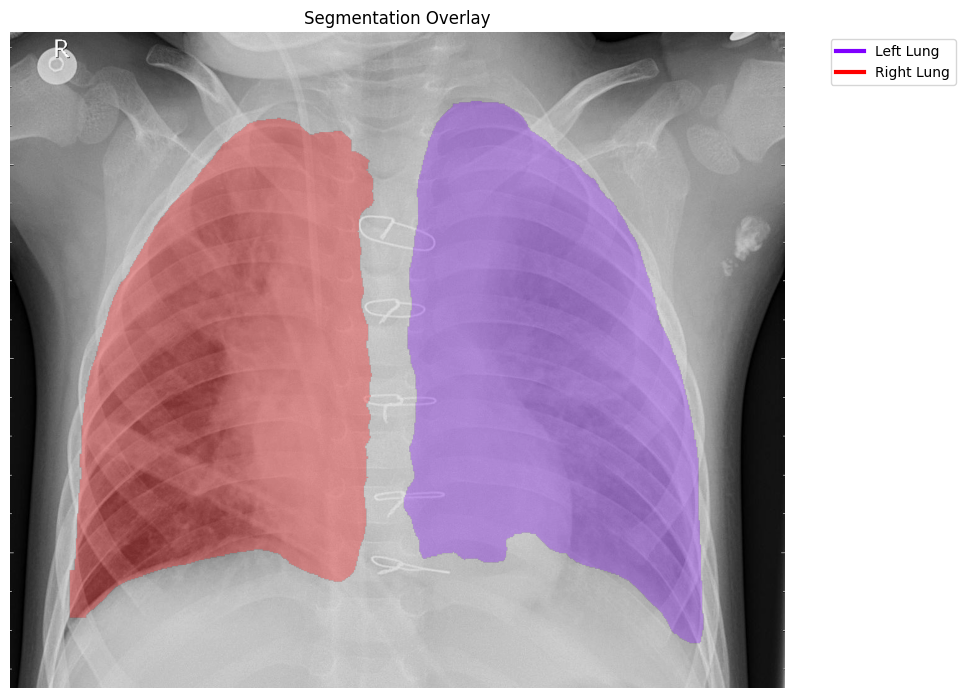

In [34]:
# messages = [HumanMessage(content="Does the image `demo/chest/pneumonia4.jpg` show pneumonia?")]
# messages = [HumanMessage(content="Provide a radiology report for the given image `demo/chest/pneumonia2.jpg`.")]
# messages = [HumanMessage(content="Descibe the given image.")]
# messages = [HumanMessage(content="What was the first question I asked?")]
# messages = [HumanMessage(content="What is the probability of pneumonia in the image `demo/chest/normal1.jpg`?")]
# messages = [HumanMessage(content="Does the patient with chest xray given here need to go see doctor? `demo/chest/normal1.jpg`")]
# messages = [HumanMessage(content="What is the size of heart?")]
# messages = [HumanMessage(content="Classify disease in the image `demo/chest/LIDC.dcm`")]
messages = [HumanMessage(content="Segment lungs in `demo/chest/pneumonia4.jpg`.")]

import shutil
shutil.rmtree("temp")

for event in agent.workflow.stream({"messages": messages}, thread):
    for v in event.values():
        print(v, '\n')

---
# **Old Interface**
---

In [ ]:
import gradio as gr
from pathlib import Path
import time
import shutil
from typing import List, Optional, Tuple
from gradio import ChatMessage

class ChatInterface:
    def __init__(self, agent):
        self.agent = agent
        self.upload_dir = Path("temp")
        self.upload_dir.mkdir(exist_ok=True)
        self.current_thread_id = None
        # Separate storage for original and display paths
        self.original_file_path = None  # For LLM (.dcm or other)
        self.display_file_path = None   # For UI (always viewable format)

    def handle_upload(self, file_path: str) -> str:
        if not file_path:
            return None
            
        source = Path(file_path)
        timestamp = int(time.time())
        
        suffix = source.suffix.lower()
        saved_path = self.upload_dir / f"upload_{timestamp}{suffix}"
        shutil.copy2(file_path, saved_path)
        self.original_file_path = str(saved_path)
        
        # Handle DICOM files
        if suffix == '.dcm':
            # Process DICOM using dicom_processor tool
            result = self.agent.workflow.tools['dicom_processor'].run(
                input_path=str(saved_path)
            )
            self.display_file_path = result['image_path']
        else:
            self.display_file_path = str(saved_path)
        
        return self.display_file_path

    async def process_message(self, 
                        message: str, 
                        display_image: Optional[str], 
                        chat_history: List[ChatMessage]) -> List[ChatMessage]:
        chat_history = chat_history or []
        
        # Use original file path if available, otherwise use display image path
        image_path = self.original_file_path or display_image
        if image_path:
            message = f"{message} `{image_path}`"
        
        # Use original file path for LLM prompt
        if self.original_file_path:
            message = f"{message} `{self.original_file_path}`"
        
        # Initialize thread if needed
        if not self.current_thread_id:
            self.current_thread_id = str(time.time())
        
        chat_history.append(ChatMessage(role="user", content=message))
        yield chat_history, self.display_file_path
        
        try:
            for event in self.agent.workflow.stream(
                {"messages": [{"role": "user", "content": message}]},
                {"configurable": {"thread_id": self.current_thread_id}}
            ):
                if isinstance(event, dict):
                    if 'process' in event:
                        content = event['process']['messages'][-1].content
                        if content:
                            chat_history.append(ChatMessage(
                                role="assistant",
                                content=content
                            ))
                            yield chat_history, self.display_file_path

                    elif 'execute' in event:
                        for message in event['execute']['messages']:
                            tool_name = message.name
                            tool_result = eval(message.content)[0]
                            
                            # For image_visualizer, use display path
                            if tool_name == "image_visualizer":
                                self.display_file_path = tool_result['image_path']
                            
                            if tool_result:
                                formatted_result = ' '.join(line.strip() for line in str(tool_result).splitlines()).strip()
                                chat_history.append(ChatMessage(
                                    role="assistant",
                                    content=formatted_result,
                                    metadata={"title": f"🔧 Using tool: {tool_name}"},
                                ))
                                yield chat_history, self.display_file_path
                            
        except Exception as e:
            chat_history.append(ChatMessage(
                role="assistant",
                content=f"❌ Error: {str(e)}",
                metadata={"title": "Error"}
            ))
            yield chat_history, self.display_file_path

def create_demo(agent):
    interface = ChatInterface(agent)
    
    with gr.Blocks(theme=gr.themes.Soft()) as demo:
        with gr.Column():
            gr.Markdown("""
            # 🏥 MedMAX
            Multimodal Medical Agent for Chest X-rays
            """)
            
            with gr.Row():
                with gr.Column(scale=3):
                    chatbot = gr.Chatbot(
                        [],
                        height=800,
                        container=True,
                        show_label=True,
                        elem_classes="chat-box",
                        type="messages",
                        label="Agent",
                        avatar_images=(None, "https://em-content.zobj.net/source/twitter/53/robot-face_1f916.png")
                    )
                    with gr.Row():
                        with gr.Column(scale=3):
                            txt = gr.Textbox(
                                show_label=False,
                                placeholder="Ask about the X-ray...",
                                container=False
                            )
                            
                with gr.Column(scale=3):
                    image_display = gr.Image(
                        label="Image",
                        type="filepath",
                        height=700,
                        container=True
                    )
                    with gr.Row():
                        upload_button = gr.UploadButton(
                            "📎 Upload X-Ray",
                            file_types=["image"],
                        )
                        dicom_upload = gr.UploadButton(
                            "📄 Upload DICOM",
                            file_types=["file"],
                        )
                    with gr.Row():
                        clear_btn = gr.Button("Clear Chat")
                        new_thread_btn = gr.Button("New Thread")

        # Event handlers
        def clear_chat():
            interface.original_file_path = None
            interface.display_file_path = None
            return [], None

        def new_thread():
            interface.current_thread_id = str(time.time())
            return [], interface.display_file_path

        def handle_file_upload(file):
            return interface.handle_upload(file.name)

        txt.submit(
            interface.process_message,
            inputs=[txt, image_display, chatbot],
            outputs=[chatbot, image_display]
        ).then(
            lambda: "",
            None,
            [txt]
        )

        upload_button.upload(
            handle_file_upload,
            inputs=upload_button,
            outputs=image_display
        )
        
        dicom_upload.upload(
            handle_file_upload,
            inputs=dicom_upload,
            outputs=image_display
        )

        clear_btn.click(clear_chat, outputs=[chatbot, image_display])
        new_thread_btn.click(new_thread, outputs=[chatbot, image_display])

    return demo

demo = create_demo(agent)
demo.launch(share=True)

---
# **Cleaned Up**
---

In [ ]:
import warnings
from typing import *
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from transformers import logging
from interface import create_demo
from medrax.agent import *
from medrax.tools import *
from medrax.utils import *

from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

warnings.filterwarnings("ignore")
logging.set_verbosity_error()
_ = load_dotenv()


def initialize_agent(prompt_file, MODEL_DIR="afallah", temp_dir="temp"):
    prompts = load_prompts_from_file(prompt_file)
    prompt = prompts["MEDICAL_ASSISTANT"]

    tools_dict = {
        "ChestXRayReportGeneratorTool": ChestXRayReportGeneratorTool(),
        "ChestXRayClassifierTool": ChestXRayClassifierTool(),
        # # # # "MedicalVisualQATool": MedicalVisualQATool(),
        "ChestXRaySegmentationTool": ChestXRaySegmentationTool(),
        "ImageVisualizerTool": ImageVisualizerTool(),
        "XRayPhraseGroundingTool": XRayPhraseGroundingTool(cache_dir=MODEL_DIR, temp_dir="temp"),
        "ChestXRayGeneratorTool": ChestXRayGeneratorTool(
            model_path=f"{MODEL_DIR}/roentgen", temp_dir="temp"
        ),
        "DicomProcessorTool": DicomProcessorTool(temp_dir="temp"),
    }

    checkpointer = MemorySaver()
    model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0, top_p=0.95)
    agent = Agent(
        model,
        tools=list(tools_dict.values()),
        log_tools=True,
        log_dir="logs",
        system_prompt=prompt,
        checkpointer=checkpointer,
    )
    return agent, tools_dict


PROMPT_FILE = "medmax/docs/system_prompts.txt"
MODEL_DIR = "/scratch/ssd004/scratch/afallah"
agent, tools_dict = initialize_agent(PROMPT_FILE, MODEL_DIR)
demo = create_demo(agent, tools_dict)
demo.launch(share=True)

---
# Garbage Zone
---

# medmax-gpt4o-notool
result2 = {
  "correct_ids": [
    "189_8353802602752",
    "189_8353801940044",
    "189_8353801943974",
    "189_8353802602581",
    "189_8353802138069",
    "201_8353802603358",
    "201_8353802130448",
    "201_8353802131171",
    "201_8353802603508",
    "201_8353802131766",
    "528_8353802602815",
    "528_8353802130481",
    "528_8353820453904",
    "528_8353802117331",
    "528_8353802129919",
    "544_8353802117994",
    "544_8353802117811",
    "544_8353802023123",
    "544_8353802117931",
    "544_8353820453910",
    "546_8353802022979",
    "546_8353802023615",
    "546_8353802131063",
    "546_8353802023594",
    "547_8353802117739",
    "547_8353802023099",
    "547_8353802118135",
    "547_8353802117481",
    "547_8353802196143",
    "548_8353802023813",
    "548_8353802131072",
    "548_8353802196275",
    "548_8353802023621",
    "548_8353802023456",
    "561_8353802023216",
    "561_8353802196203",
    "561_8353802196413",
    "561_8353802117976",
    "562_8353802023537",
    "562_8353802023471",
    "562_8353802130943",
    "564_8353802117895",
    "564_8353802118000",
    "565_8353802196815",
    "565_8353802196617",
    "565_8353802196104",
    "565_8353802022919",
    "565_8353802023627",
    "568_8353802196329",
    "568_8353802196947",
    "568_8353802117688",
    "568_8353802196416",
    "590_8353802196485",
    "590_8353802023813",
    "590_8353802185819",
    "590_8353802023876",
    "590_8353802117997",
    "606_8353802118108",
    "606_8353802196914",
    "612_8353802023486",
    "612_8353802130487",
    "612_8353802196575",
    "612_8353802117847",
    "612_8353820454606",
    "722_8353802117601",
    "724_8353802196353",
    "724_8353802023738",
    "724_8353802196098",
    "724_8353802185080",
    "724_8353802184939",
    "727_8353802184954",
    "727_8353802185218",
    "727_8353802131171",
    "727_8353802117769",
    "734_8353802196296",
    "734_8353802185350",
    "734_8353802196659",
    "734_8353802184708",
    "734_8353802196866",
    "740_8353802184945",
    "740_8353802023390",
    "740_8353802185362",
    "740_8353802185485",
    "757_8353802196899",
    "757_8353802185038",
    "757_8353802196338",
    "757_8353802185617",
    "757_8353802184786",
    "766_8353802185224",
    "766_8353802181657",
    "766_8353802184996",
    "766_8353802117790",
    "793_8353802196635",
    "793_8353802185587",
    "793_8353802159261",
    "793_8353802196143",
    "793_8353802131015",
    "794_8353802185455",
    "794_8353802159399",
    "794_8353802117475",
    "794_8353802184828",
    "795_8353802159426",
    "795_8353802185482",
    "795_8353802159534",
    "797_8353802196515",
    "797_8353802159462",
    "797_8353802196185",
    "797_8353802023654",
    "806_8353802185404",
    "806_8353802159306",
    "806_8353802185416",
    "806_8353802023444",
    "806_8353802185023",
    "813_8353802117574",
    "813_8353802196083",
    "813_8353802159219",
    "813_8353802195984",
    "816_8353802185068",
    "816_8353802185266",
    "816_8353802159558",
    "816_8353802159651",
    "881_8353802196266",
    "881_8353802196608",
    "881_8353802117829",
    "881_8353802159783",
    "896_8353802159915",
    "896_8353802159813",
    "896_8353802184963",
    "896_8353802159342",
    "912_8353802159612",
    "912_8353802160047",
    "912_8353802117637",
    "912_8353802159336",
    "919_8353802159390",
    "919_8353802159294",
    "919_8353802281015",
    "919_8353802159699",
    "919_8353802185707",
    "934_8353802117892",
    "934_8353802196971",
    "934_8353802281147",
    "934_8353802185302",
    "934_8353802159612",
    "940_8353802159807",
    "940_8353802159942",
    "940_8353802159549",
    "940_8353802185218",
    "940_8353802281282",
    "943_8353802281333",
    "943_8353802281414",
    "943_8353802023426",
    "943_8353802184960",
    "943_8353802184945",
    "947_8353802159657",
    "947_8353802159963",
    "947_8353802159363",
    "957_8353802185218",
    "957_8353802185089",
    "957_8353802196443",
    "957_8353802281327",
    "957_8353802023105",
    "1025_8353802281075",
    "1025_8353802281120",
    "1025_8353802196872",
    "1147_8353802196317",
    "1198_8353802023366",
    "1198_8353802281651",
    "1198_8353802159960",
    "1198_8353802159609",
    "1223_8353820454426",
    "1223_8353802281708",
    "1223_8353802159363",
    "1281_8353802196620",
    "1281_8353802281915",
    "1281_8353802281357",
    "1281_8353802159945",
    "1281_8353802281594",
    "1329_8353802281615",
    "1329_8353802281801",
    "1329_8353802277955",
    "1343_8353802196434",
    "1343_8353802281924",
    "1343_8353802159675",
    "1343_8353802279111",
    "1343_8353802184723",
    "1373_8353802281393",
    "1373_8353802279243",
    "1373_8353802280997",
    "1373_8353802023585",
    "1389_8353802185329",
    "1389_8353802279378",
    "1389_8353802278946",
    "1389_8353802185164",
    "1389_8353802159873",
    "1437_8353802279030",
    "1437_8353802281465",
    "1437_8353802279144",
    "1437_8353802196017",
    "1461_8353802279324",
    "1461_8353802279666",
    "1461_8353802185476",
    "1461_8353802023456",
    "1568_8353802279609",
    "1568_8353802196716",
    "1568_8353802159435",
    "1568_8353802159126",
    "1568_8353802279483",
    "1583_8353802279573",
    "1583_8353802279471",
    "1583_8353802279744",
    "1583_8353802281723",
    "1583_8353802281003",
    "1606_8353802279651",
    "1606_8353802279450",
    "1606_8353802279309",
    "1606_8353802196719",
    "1618_8353802281549",
    "1618_8353802159165",
    "1618_8353802280964",
    "1618_8353802257487",
    "1637_8353802279822",
    "1637_8353802185065",
    "1653_8353802023639",
    "1673_8353802279432",
    "1673_8353802279822",
    "1673_8353802279528",
    "1673_8353802257883",
    "1676_8353802159837",
    "1676_8353802281018",
    "1676_8353802281492",
    "1676_8353802258015",
    "1676_8353802257601",
    "1678_8353802257481",
    "1678_8353802258147",
    "1678_8353802279918",
    "1678_8353802279576",
    "1678_8353802257991",
    "1701_8353802281393",
    "1701_8353802258102",
    "1701_8353802258288",
    "1701_8353802279483",
    "1701_8353802257634",
    "1720_8353802279243",
    "1720_8353802159642",
    "1720_8353802281759",
    "1720_8353802258075",
    "1767_8353802279810",
    "1767_8353802279279",
    "1767_8353802257574",
    "1801_8353802281246",
    "1801_8353802257454",
    "1801_8353802132393",
    "1801_8353802257610",
    "1801_8353802258195",
    "1822_8353802257763",
    "1822_8353802258390",
    "1822_8353802258075",
    "1822_8353802279765",
    "1822_8353802258057",
    "1833_8353802248286",
    "1833_8353802117877",
    "1833_8353802257454",
    "1833_8353802279141",
    "1833_8353802281873",
    "1847_8353802257637",
    "1847_8353802258408",
    "1847_8353802257685",
    "1847_8353802279846",
    "1847_8353802248418",
    "1882_8353802248409",
    "1885_8353802257493",
    "1885_8353802258084",
    "1895_8353802279543",
    "1895_8353802185011",
    "1895_8353802159447",
    "1895_8353802248823",
    "1895_8353802248205",
    "1904_8353802248805",
    "1904_8353802248403",
    "1904_8353802257910",
    "1904_8353802257748",
    "1904_8353802248955",
    "1910_8353802279201",
    "1910_8353802281705",
    "1968_8353802258354",
    "1968_8353801506823",
    "1968_8353802248865",
    "1975_8353802249120",
    "1975_8353802257622",
    "1975_8353802258366",
    "1975_8353802258387",
    "1978_8353802249009",
    "1978_8353802281276",
    "1978_8353802248553",
    "1978_8353802279708",
    "2006_8353802258327",
    "2006_8353802023654",
    "2024_8353802278988",
    "2024_8353802159837",
    "2024_8353801509997",
    "2038_8353801510129",
    "2038_8353802258135",
    "2038_8353802281576",
    "2038_8353802248364",
    "2046_8353802248709",
    "2046_8353820454567",
    "2046_8353801511285",
    "2046_8353802159168",
    "2046_8353801510928",
    "2093_8353801511060",
    "2093_8353802185506",
    "2124_8353801511549",
    "2124_8353802279294",
    "2124_8353802248496",
    "2124_8353801511216",
    "2180_8353801511681",
    "2180_8353802257439",
    "2180_8353801511555",
    "2180_8353802258345",
    "2206_8353801511234",
    "2206_8353802279498",
    "2206_8353801511813",
    "2206_8353801511555",
    "2243_8353801511231",
    "2243_8353801511633"
  ],
  "incorrect_ids": [
    "546_8353802196008",
    "561_8353802117901",
    "562_8353802196551",
    "562_8353802196110",
    "564_8353802196683",
    "564_8353802196083",
    "564_8353802117475",
    "568_8353802196263",
    "606_8353802196674",
    "606_8353802185951",
    "606_8353802196065",
    "682_8353802184804",
    "682_8353802023651",
    "682_8353802196233",
    "682_8353802196455",
    "682_8353802196242",
    "722_8353802130694",
    "722_8353802196845",
    "722_8353802184942",
    "722_8353802131015",
    "727_8353802117919",
    "740_8353802130475",
    "766_8353802184903",
    "794_8353802185434",
    "795_8353802131057",
    "795_8353802196878",
    "797_8353802130883",
    "813_8353802159117",
    "816_8353802185650",
    "881_8353802159519",
    "896_8353802184906",
    "912_8353802196305",
    "947_8353802281135",
    "947_8353802281549",
    "1025_8353802159498",
    "1025_8353802159546",
    "1147_8353802185083",
    "1147_8353802281459",
    "1147_8353802117655",
    "1147_8353802281276",
    "1198_8353802160122",
    "1223_8353802281588",
    "1223_8353802281783",
    "1329_8353802281522",
    "1329_8353802023567",
    "1373_8353802281777",
    "1402_8353802281555",
    "1402_8353802281042",
    "1402_8353802279030",
    "1402_8353802281495",
    "1402_8353802279513",
    "1437_8353802279645",
    "1461_8353802159822",
    "1483_8353802281825",
    "1483_8353802279573",
    "1483_8353802281585",
    "1483_8353802278976",
    "1483_8353802281018",
    "1606_8353802279879",
    "1618_8353802279273",
    "1637_8353802279597",
    "1637_8353802257634",
    "1637_8353802279846",
    "1653_8353802257751",
    "1653_8353802281156",
    "1653_8353802281723",
    "1653_8353802281519",
    "1673_8353802257613",
    "1720_8353802257439",
    "1767_8353802279528",
    "1882_8353802185011",
    "1882_8353802023510",
    "1882_8353802248559",
    "1882_8353802257721",
    "1885_8353802248691",
    "1885_8353802257826",
    "1885_8353802248508",
    "1910_8353802249087",
    "1910_8353802248250",
    "1910_8353802248913",
    "1968_8353802248484",
    "1968_8353802248415",
    "1975_8353802279258",
    "2006_8353802248550",
    "2006_8353802185581",
    "2006_8353802257445",
    "2024_8353802249192",
    "2024_8353802159549",
    "2038_8353802257973",
    "2093_8353802132393",
    "2093_8353802257460",
    "2093_8353801511417",
    "2124_8353802248265",
    "2180_8353801511102",
    "2206_8353802248325",
    "2243_8353801512973",
    "2243_8353802280976"
  ]
}

# gpt4o
result = {
  "correct_ids": [
    "189_8353801940044",
    "189_8353801943974",
    "189_8353802138069",
    "189_8353802602581",
    "189_8353802602752",
    "201_8353802130448",
    "201_8353802131171",
    "201_8353802603508",
    "528_8353802117331",
    "528_8353802129919",
    "528_8353802602815",
    "544_8353802023123",
    "544_8353802117811",
    "544_8353802117931",
    "544_8353802117994",
    "544_8353820453910",
    "546_8353802022979",
    "546_8353802023615",
    "546_8353802131063",
    "547_8353802023099",
    "547_8353802117481",
    "547_8353802117739",
    "547_8353802118135",
    "548_8353802023621",
    "548_8353802131072",
    "548_8353802196275",
    "561_8353802196203",
    "561_8353802196413",
    "562_8353802023471",
    "562_8353802196551",
    "564_8353802117895",
    "564_8353802118000",
    "564_8353802196083",
    "565_8353802023627",
    "565_8353802196104",
    "565_8353802196617",
    "565_8353802196815",
    "568_8353802117688",
    "568_8353802196416",
    "590_8353802023813",
    "590_8353802023876",
    "590_8353802196485",
    "606_8353802185951",
    "606_8353802196065",
    "606_8353802196914",
    "612_8353802117847",
    "612_8353802130487",
    "612_8353802196575",
    "612_8353820454606",
    "682_8353802184804",
    "682_8353802196242",
    "682_8353802196455",
    "724_8353802023738",
    "724_8353802196098",
    "724_8353802196353",
    "727_8353802117769",
    "727_8353802131171",
    "727_8353802184954",
    "727_8353802185218",
    "734_8353802184708",
    "734_8353802196296",
    "734_8353802196659",
    "734_8353802196866",
    "740_8353802023390",
    "740_8353802130475",
    "740_8353802184945",
    "740_8353802185362",
    "740_8353802185485",
    "757_8353802184786",
    "757_8353802185038",
    "757_8353802185617",
    "757_8353802196338",
    "757_8353802196899",
    "766_8353802181657",
    "793_8353802131015",
    "793_8353802159261",
    "793_8353802185587",
    "793_8353802196143",
    "794_8353802117475",
    "794_8353802159399",
    "794_8353802184828",
    "794_8353802185455",
    "795_8353802159426",
    "795_8353802159534",
    "795_8353802185482",
    "797_8353802023654",
    "797_8353802196185",
    "797_8353802196515",
    "806_8353802023444",
    "806_8353802159306",
    "806_8353802185023",
    "806_8353802185404",
    "806_8353802185416",
    "816_8353802185068",
    "816_8353802185266",
    "881_8353802117829",
    "881_8353802159783",
    "881_8353802196266",
    "881_8353802196608",
    "896_8353802159915",
    "912_8353802117637",
    "912_8353802159336",
    "912_8353802159612",
    "919_8353802159390",
    "919_8353802159699",
    "919_8353802185707",
    "919_8353802281015",
    "934_8353802159612",
    "934_8353802185302",
    "934_8353802196971",
    "934_8353802281147",
    "940_8353802159549",
    "940_8353802159807",
    "940_8353802159942",
    "940_8353802185218",
    "943_8353802023426",
    "943_8353802184945",
    "943_8353802281333",
    "947_8353802159363",
    "947_8353802159657",
    "947_8353802159963",
    "947_8353802281135",
    "947_8353802281549",
    "957_8353802023105",
    "957_8353802185218",
    "957_8353802196443",
    "957_8353802281327",
    "1025_8353802159546",
    "1025_8353802196872",
    "1025_8353802281120",
    "1147_8353802117655",
    "1147_8353802196317",
    "1147_8353802281276",
    "1198_8353802023366",
    "1198_8353802159609",
    "1198_8353802159960",
    "1198_8353802160122",
    "1198_8353802281651",
    "1223_8353802281588",
    "1223_8353802281708",
    "1223_8353802281783",
    "1223_8353820454426",
    "1281_8353802159945",
    "1281_8353802196620",
    "1281_8353802281357",
    "1281_8353802281594",
    "1329_8353802277955",
    "1329_8353802281615",
    "1329_8353802281801",
    "1343_8353802184723",
    "1343_8353802196434",
    "1343_8353802279111",
    "1343_8353802281924",
    "1373_8353802279243",
    "1373_8353802281393",
    "1389_8353802159873",
    "1389_8353802185164",
    "1389_8353802185329",
    "1389_8353802278946",
    "1389_8353802279378",
    "1402_8353802279513",
    "1437_8353802196017",
    "1437_8353802279030",
    "1437_8353802279144",
    "1437_8353802281465",
    "1461_8353802023456",
    "1461_8353802185476",
    "1461_8353802279324",
    "1483_8353802278976",
    "1483_8353802281825",
    "1568_8353802159126",
    "1568_8353802159435",
    "1568_8353802196716",
    "1568_8353802279483",
    "1568_8353802279609",
    "1583_8353802279471",
    "1583_8353802279573",
    "1583_8353802281003",
    "1583_8353802281723",
    "1606_8353802196719",
    "1606_8353802279309",
    "1606_8353802279450",
    "1606_8353802279651",
    "1606_8353802279879",
    "1618_8353802159165",
    "1618_8353802280964",
    "1618_8353802281549",
    "1637_8353802185065",
    "1637_8353802279597",
    "1637_8353802279822",
    "1637_8353802279846",
    "1653_8353802257751",
    "1673_8353802257613",
    "1673_8353802257883",
    "1673_8353802279432",
    "1676_8353802159837",
    "1676_8353802258015",
    "1676_8353802281492",
    "1678_8353802257481",
    "1678_8353802257991",
    "1678_8353802279576",
    "1678_8353802279918",
    "1701_8353802257634",
    "1701_8353802258102",
    "1701_8353802258288",
    "1701_8353802279483",
    "1701_8353802281393",
    "1720_8353802159642",
    "1720_8353802279243",
    "1767_8353802257574",
    "1767_8353802257730",
    "1767_8353802279279",
    "1767_8353802279810",
    "1801_8353802132393",
    "1801_8353802257454",
    "1801_8353802257610",
    "1801_8353802281246",
    "1822_8353802257763",
    "1822_8353802258057",
    "1822_8353802258075",
    "1822_8353802258390",
    "1822_8353802279765",
    "1833_8353802117877",
    "1833_8353802248286",
    "1833_8353802257454",
    "1833_8353802281873",
    "1847_8353802257637",
    "1847_8353802257685",
    "1847_8353802258408",
    "1885_8353802248508",
    "1885_8353802257493",
    "1895_8353802159447",
    "1895_8353802185011",
    "1895_8353802248205",
    "1895_8353802248823",
    "1904_8353802248403",
    "1904_8353802248805",
    "1904_8353802248955",
    "1904_8353802257748",
    "1904_8353802257910",
    "1910_8353802248250",
    "1910_8353802249087",
    "1910_8353802279201",
    "1968_8353802248865",
    "1968_8353802258354",
    "1975_8353802249120",
    "1975_8353802257622",
    "1975_8353802258366",
    "1975_8353802258387",
    "1975_8353802279258",
    "1978_8353802248553",
    "1978_8353802249009",
    "1978_8353802279708",
    "1978_8353802281276",
    "2006_8353802258327",
    "2024_8353801509997",
    "2024_8353802159549",
    "2024_8353802159837",
    "2024_8353802278988",
    "2038_8353801510129",
    "2038_8353802248364",
    "2038_8353802258135",
    "2038_8353802281576",
    "2046_8353802159168",
    "2046_8353802248709",
    "2046_8353820454567",
    "2093_8353801511060",
    "2093_8353802185506",
    "2124_8353801511549",
    "2124_8353802248496",
    "2124_8353802279294",
    "2180_8353801511555",
    "2180_8353801511681",
    "2180_8353802257439",
    "2206_8353801511234",
    "2206_8353801511555",
    "2206_8353801511813",
    "2206_8353802248325",
    "2206_8353802279498",
    "2243_8353801511108",
    "2243_8353801511231",
    "2243_8353801511633",
    "2243_8353801512973",
    "2243_8353802280976",
    "2364_8353802279708",
    "2417_8353801510943",
    "2417_8353802248715",
    "2424_8353801511327",
    "2424_8353801514078",
    "2424_8353802257487",
    "2424_8353802279138",
    "2424_8353802279855",
    "2457_8353801511822",
    "2457_8353801514234",
    "2457_8353802248241",
    "2457_8353802248367",
    "2457_8353802281126",
    "2465_8353801515033",
    "2465_8353801515390",
    "2465_8353802159300",
    "2465_8353802281225",
    "2490_8353801515351",
    "2490_8353802249180",
    "2490_8353802249201",
    "2626_8353801515198",
    "2626_8353802159822",
    "2626_8353802257973",
    "2819_8353801515360",
    "2847_8353801515192",
    "2847_8353801515240",
    "2847_8353801515555",
    "2847_8353801518108",
    "2847_8353802248919",
    "2908_8353801510982",
    "2908_8353801511615",
    "2908_8353801515384",
    "2908_8353801518240",
    "2908_8353802159615",
    "2919_8353801515174",
    "2919_8353801515735",
    "2944_8353801511603",
    "2944_8353801511654",
    "2944_8353801511906",
    "2944_8353801515177",
    "3028_8353801511750",
    "3028_8353801515087",
    "3028_8353801519366",
    "3028_8353802279258",
    "3129_8353801515495",
    "3129_8353801520165",
    "3148_8353801510997",
    "3148_8353801511912",
    "3148_8353801520285",
    "3148_8353801520696",
    "3205_8353801515030",
    "3205_8353801520192",
    "3205_8353801520828",
    "3205_8353802185581",
    "3241_8353801520855",
    "3241_8353801520960",
    "3241_8353802249030",
    "3241_8353802279495",
    "3359_8353801515597",
    "3359_8353801520966",
    "3359_8353801521228",
    "3359_8353802248430",
    "3359_8353802279231",
    "3375_8353801515375",
    "3375_8353801520381",
    "3375_8353801520504",
    "3375_8353801521053",
    "3378_8353801523540",
    "3397_8353801520408",
    "3397_8353801520783",
    "3397_8353801521041",
    "3397_8353801523672",
    "3436_8353801515738",
    "3436_8353801515777",
    "3436_8353802248805",
    "3546_8353801520846",
    "3546_8353802248199",
    "3546_8353802279000",
    "3561_8353801511489",
    "3561_8353801515588",
    "3561_8353801515996",
    "3561_8353801523264",
    "3561_8353801523315",
    "3686_8353801520174",
    "3686_8353801520828",
    "3686_8353802279444",
    "3703_8353801511498",
    "3703_8353801515426",
    "3703_8353801523921",
    "3831_8353801523774",
    "3831_8353801523843",
    "3831_8353801524038",
    "3834_8353801515327",
    "3834_8353801523222",
    "3834_8353801523471",
    "3834_8353801523951",
    "3834_8353801524170",
    "3842_8353801524020",
    "3842_8353801527378",
    "3842_8353802248934",
    "3842_8353802279411",
    "3890_8353801515507",
    "3890_8353801523318",
    "3890_8353801523705",
    "3918_8353801511210",
    "3918_8353801520150",
    "3918_8353801527642",
    "3918_8353802257859",
    "3918_8353802279918",
    "3927_8353801523714",
    "3927_8353801523765",
    "3927_8353801524146",
    "3927_8353801527303",
    "3927_8353801527783",
    "4005_8353801520684",
    "4005_8353801527324",
    "4068_8353801520696",
    "4068_8353801520726",
    "4068_8353801521059",
    "4068_8353801527612",
    "4092_8353801527390",
    "4092_8353801527576",
    "4092_8353802132249",
    "4113_8353801511612",
    "4113_8353801520576",
    "4113_8353801521146",
    "4113_8353801527309",
    "4113_8353801527834",
    "4118_8353801528005",
    "4124_8353801515687",
    "4124_8353801527642",
    "4124_8353801527963",
    "4124_8353801528137",
    "4131_8353801523501",
    "4131_8353801527348",
    "4131_8353801527507",
    "4131_8353801527822",
    "4131_8353801528269",
    "4295_8353801521020",
    "4295_8353801524128",
    "4295_8353801528068",
    "4379_8353801527738",
    "4379_8353801527837",
    "4469_8353801523921",
    "4469_8353801527717",
    "4469_8353801532765",
    "4469_8353802279243",
    "4473_8353801528008",
    "4491_8353801520807",
    "4491_8353801523228",
    "4491_8353801523954",
    "4491_8353801532828",
    "4491_8353801533029",
    "4493_8353801527558",
    "4493_8353801528011",
    "4493_8353801532711",
    "4493_8353801533161",
    "4494_8353801532948",
    "4494_8353801533188",
    "4494_8353802278931",
    "4510_8353801520198",
    "4510_8353801527726",
    "4510_8353801528056",
    "4510_8353801532552",
    "4510_8353801532849",
    "4516_8353801511021",
    "4516_8353801520684",
    "4516_8353801524113",
    "4516_8353801533056",
    "4516_8353801533197",
    "4594_8353801515630",
    "4594_8353801527906",
    "4594_8353801532552",
    "4594_8353801532882",
    "4594_8353801533263",
    "4650_8353801523891",
    "4650_8353801532594",
    "4650_8353801532603",
    "4650_8353801533188",
    "4670_8353801515741",
    "4670_8353801520867",
    "4670_8353801527939",
    "4670_8353801533035",
    "4671_8353801532570",
    "4671_8353801532960",
    "4671_8353801532999",
    "4671_8353801538783",
    "4718_8353801515705",
    "4718_8353801539939",
    "4718_8353802159168",
    "4734_8353801532672",
    "4734_8353801532720",
    "4734_8353801533374",
    "4734_8353801539873",
    "4734_8353801540071",
    "4810_8353801520969",
    "4810_8353801528317",
    "4810_8353801540209",
    "4921_8353801527852",
    "4921_8353801533023",
    "4921_8353801539615",
    "4921_8353801540467",
    "4924_8353801521113",
    "4924_8353801523936",
    "4924_8353801527489",
    "4924_8353801539810",
    "5047_8353801511588",
    "5047_8353801539591",
    "5047_8353801539897",
    "5047_8353801540131",
    "5060_8353801533047",
    "5060_8353801539735",
    "5060_8353801540431",
    "5060_8353801540446",
    "5060_8353801540566",
    "5101_8353801527939",
    "5101_8353801532672",
    "5101_8353801539663",
    "5101_8353801542750",
    "5107_8353801532963",
    "5107_8353801540095",
    "5107_8353801540485",
    "5107_8353801542882",
    "5202_8353801520792",
    "5202_8353801540047",
    "5246_8353801540527",
    "5246_8353801543146",
    "5288_8353801532921",
    "5288_8353801542918",
    "5288_8353801543278",
    "5294_8353801539741",
    "5294_8353801540365",
    "5294_8353801542909",
    "5294_8353801543260",
    "5294_8353801543410",
    "5295_8353801527378",
    "5295_8353801532558",
    "5295_8353801543368",
    "5295_8353801543542",
    "5343_8353801540200",
    "5343_8353801543182",
    "5343_8353801543200",
    "5343_8353801543320",
    "5343_8353801543674",
    "5369_8353801540122",
    "5401_8353801539903",
    "5401_8353801542720",
    "5533_8353801540251",
    "5533_8353801543014",
    "5533_8353801543059",
    "5533_8353801548897",
    "5550_8353801523249",
    "5550_8353801533359",
    "5550_8353802279594",
    "5654_8353801542834",
    "5707_8353801532810",
    "5715_8353801543278",
    "5715_8353801543653",
    "5744_8353801527852",
    "5744_8353801527870",
    "5744_8353801548879",
    "5744_8353801549401",
    "5744_8353801549563",
    "5844_8353801543146",
    "5844_8353801543290",
    "5844_8353801549101",
    "5844_8353801549497",
    "5844_8353801549695",
    "5845_8353801548963",
    "5845_8353801549134",
    "5845_8353801549284",
    "5859_8353801527420",
    "5859_8353801548939",
    "5859_8353801549674",
    "5862_8353801532450",
    "5862_8353801543113",
    "5862_8353801543476",
    "5862_8353801548936",
    "5970_8353801542861",
    "5970_8353801543116",
    "5970_8353801549068",
    "5970_8353801549362",
    "6023_8353801543050",
    "6023_8353801549068",
    "6023_8353801553140",
    "6026_8353801549365",
    "6026_8353801552915",
    "6066_8353801553410",
    "6109_8353801539900",
    "6109_8353801553290",
    "6109_8353801553536",
    "6111_8353801543284",
    "6111_8353801543659",
    "6111_8353801553194",
    "6111_8353801553548",
    "6111_8353801553668",
    "6303_8353801540353",
    "6303_8353801553800",
    "6311_8353801553284",
    "6311_8353801553629",
    "6311_8353801557008",
    "6312_8353801549533",
    "6312_8353801553782",
    "6314_8353801553254",
    "6314_8353801553419",
    "6374_8353801528149",
    "6374_8353801540437",
    "6399_8353801543350",
    "6399_8353801553230",
    "6399_8353801553488",
    "6399_8353801558248",
    "6457_8353801532549",
    "6457_8353801533392",
    "6457_8353801543380",
    "6457_8353801558269",
    "6508_8353801540422",
    "6508_8353801553191",
    "6508_8353801553617",
    "6508_8353801559068",
    "6508_8353801559425",
    "6519_8353801549020",
    "6519_8353801549533",
    "6519_8353801559386",
    "6519_8353801559557",
    "6529_8353801553098",
    "6529_8353801559689",
    "6551_8353801532654",
    "6551_8353801543674",
    "6551_8353801559173",
    "6551_8353801559698",
    "6551_8353801559821",
    "6577_8353801559617",
    "6586_8353801549446",
    "6586_8353801559746",
    "6586_8353801562137",
    "6632_8353801543185",
    "6632_8353801552900",
    "6632_8353801553491",
    "6632_8353801559626",
    "6632_8353801562269",
    "6670_8353801549557",
    "6670_8353801559365",
    "6670_8353801559812",
    "6670_8353801563425",
    "6672_8353801520249",
    "6672_8353801553263",
    "6672_8353801559284",
    "6678_8353801542891",
    "6678_8353801549065",
    "6678_8353801552933",
    "6695_8353801559245",
    "6695_8353801559494",
    "6695_8353801563173",
    "6759_8353801559272",
    "6759_8353801559440",
    "6759_8353801563293",
    "6822_8353801553599",
    "6822_8353801567527",
    "6822_8353801567884",
    "6860_8353801559557",
    "6860_8353801560028",
    "6860_8353801567689",
    "6860_8353801568016",
    "6939_8353801559599",
    "6939_8353801567437",
    "6939_8353801567893",
    "6972_8353800850463",
    "6972_8353801559179",
    "6972_8353801559365",
    "6972_8353801567476",
    "7004_8353800850538",
    "7004_8353800850883",
    "7004_8353801567437",
    "7018_8353800851015",
    "7018_8353801567968",
    "7022_8353800850574",
    "7022_8353800851153",
    "7022_8353801553425",
    "7022_8353801559593",
    "7074_8353800851330",
    "7074_8353801559593",
    "7074_8353801567716",
    "7074_8353801567794",
    "7129_8353801542687",
    "7129_8353801559326",
    "7129_8353801559527",
    "7135_8353800850460",
    "7135_8353801567236",
    "7135_8353801567404",
    "7135_8353801567758",
    "7135_8353801568013",
    "7150_8353800850544",
    "7150_8353800850967",
    "7150_8353801548837",
    "7150_8353801567785",
    "7181_8353800850631",
    "7181_8353800850889",
    "7181_8353801553404",
    "7181_8353801567386",
    "7181_8353801567887",
    "7197_8353800850892",
    "7197_8353800851216",
    "7197_8353801553161",
    "7197_8353801559755",
    "7197_8353801567866",
    "7214_8353800851273",
    "7214_8353800851399",
    "7214_8353801567437",
    "7214_8353801567584",
    "7236_8353800861781",
    "7236_8353801543428",
    "7239_8353800850643",
    "7271_8353801568145",
    "7277_8353800850472",
    "7277_8353800861949",
    "7277_8353800862177",
    "7277_8353801567413",
    "7354_8353800862084",
    "7354_8353800862309",
    "7354_8353801567395",
    "7368_8353800850583",
    "7368_8353800850679",
    "7368_8353800861874",
    "7368_8353800862441",
    "7368_8353801559731",
    "7438_8353800861769",
    "7438_8353800862429",
    "7438_8353801559911",
    "7438_8353801567272",
    "7475_8353800850760",
    "7475_8353800861886",
    "7475_8353800862048",
    "7475_8353801567761",
    "7479_8353800862363",
    "7479_8353800862492",
    "7479_8353801553203",
    "7479_8353801559071",
    "7479_8353801568115",
    "7484_8353800862540",
    "7575_8353800861838",
    "7575_8353800862306",
    "7575_8353801567983",
    "7588_8353800850991",
    "7588_8353801553374",
    "7588_8353801559578",
    "7588_8353801567923",
    "7603_8353800862555",
    "7603_8353800871132",
    "7627_8353800862099",
    "7627_8353800862438",
    "7627_8353800871132",
    "7627_8353800871396",
    "7627_8353801568184",
    "7655_8353800851240",
    "7655_8353800871126",
    "7655_8353800871528",
    "7659_8353800862549",
    "7659_8353800871084",
    "7659_8353800871660",
    "7659_8353801567797",
    "7724_8353800850745",
    "7724_8353800871438",
    "7724_8353800871792",
    "7726_8353800862627",
    "7726_8353800871273",
    "7726_8353800871786",
    "7726_8353801553872",
    "7726_8353801567449",
    "7735_8353800850721",
    "7735_8353800861727",
    "7735_8353800861937",
    "7735_8353800871363",
    "7735_8353800871528",
    "7738_8353800850751",
    "7738_8353800862717",
    "7738_8353800871381",
    "7738_8353800871540",
    "7738_8353801568121",
    "7744_8353800871168",
    "7744_8353800871891",
    "7744_8353801559134",
    "7762_8353800850976",
    "7762_8353800861967",
    "7762_8353800862156",
    "7762_8353800879195",
    "7762_8353801553062",
    "7819_8353800862357",
    "7819_8353800871864",
    "7819_8353800871906",
    "7819_8353800871918",
    "7819_8353800879333",
    "7903_8353800879459",
    "7903_8353801540125",
    "7903_8353801567278",
    "7913_8353800871141",
    "7913_8353800879369",
    "7920_8353800850643",
    "7920_8353800879501",
    "7920_8353800879723",
    "7923_8353800862030",
    "7923_8353800871345",
    "7923_8353800879366",
    "7923_8353801559377",
    "7978_8353800861925",
    "7978_8353800879987",
    "7978_8353801511723",
    "8005_8353800871348",
    "8005_8353800879351",
    "8005_8353800879450",
    "8005_8353800879522",
    "8005_8353800880119",
    "8043_8353800862375",
    "8043_8353800862618",
    "8043_8353800862636",
    "8043_8353800871822",
    "8092_8353800851240",
    "8092_8353800879543",
    "8092_8353800879588",
    "8092_8353801568097",
    "8129_8353800850742",
    "8129_8353800862165",
    "8129_8353800862240",
    "8129_8353800870916",
    "8167_8353800850820",
    "8167_8353800879723",
    "8167_8353800888414",
    "8255_8353800871168",
    "8255_8353800888546",
    "8255_8353801568052",
    "8257_8353800871309",
    "8257_8353800879108",
    "8257_8353800879234",
    "8257_8353800879636",
    "8265_8353800861760",
    "8265_8353800871774",
    "8265_8353800888534",
    "8275_8353800862645",
    "8275_8353800871888",
    "8275_8353800879912",
    "8275_8353800888549",
    "8275_8353800888942",
    "8300_8353800861859",
    "8300_8353800871180",
    "8300_8353800888579",
    "8300_8353800889074",
    "8300_8353801567659",
    "8303_8353800862687",
    "8303_8353800871366",
    "8379_8353800888555",
    "8379_8353800888984",
    "8379_8353800889338",
    "8379_8353801567659",
    "8379_8353801568190",
    "8392_8353800871930",
    "8392_8353800880083",
    "8392_8353800888690",
    "8392_8353800889203",
    "8392_8353800898690",
    "8447_8353800879144",
    "8447_8353800879903",
    "8447_8353801567479",
    "8486_8353800871087",
    "8486_8353800888375",
    "8486_8353800888591",
    "8486_8353800889011",
    "8549_8353800879324",
    "8555_8353800871534",
    "8555_8353800889266",
    "8555_8353800898792",
    "8571_8353800861748",
    "8571_8353800862648",
    "8571_8353800879510",
    "8571_8353800888495",
    "8575_8353800899056",
    "8575_8353801567473",
    "8577_8353800879387",
    "8577_8353800888543",
    "8577_8353800898762",
    "8577_8353800899188",
    "8577_8353801567272",
    "8584_8353800871099",
    "8584_8353800888531",
    "8584_8353800899320",
    "8584_8353801567950",
    "8589_8353800879822",
    "8589_8353800888672",
    "8589_8353800899119",
    "8589_8353800899452",
    "8617_8353800871174",
    "8617_8353800908810",
    "8653_8353800862633",
    "8653_8353801567980",
    "8670_8353800898753",
    "8683_8353800889053",
    "8683_8353802137613",
    "8683_8353802138570",
    "8720_8353802129895",
    "8720_8353802130535",
    "8720_8353802137817",
    "8804_8353800879969",
    "8804_8353801943731",
    "8804_8353801943812",
    "8804_8353802138429",
    "8817_8353800871456",
    "8817_8353801549494",
    "8817_8353802131760",
    "8817_8353802132060",
    "8817_8353802196632",
    "8911_8353800871456",
    "8911_8353802131817",
    "8911_8353802603238",
    "8911_8353802603277",
    "8921_8353801548807",
    "8921_8353801549050",
    "8921_8353802132462",
    "8921_8353802602704",
    "8921_8353802602851",
    "8926_8353801940920",
    "8926_8353802132216",
    "8926_8353802603265",
    "8935_8353801940437",
    "8935_8353802131982",
    "8935_8353802196599",
    "8935_8353802602791",
    "8953_8353800909047",
    "8953_8353801940659",
    "8953_8353802602842",
    "8955_8353800888726",
    "8955_8353800908972",
    "8955_8353802602884",
    "8961_8353800908969",
    "8961_8353801539927",
    "8961_8353801940083",
    "8961_8353801940116",
    "8961_8353801940968",
    "9009_8353800909137",
    "9009_8353801548807",
    "9049_8353800908921",
    "9049_8353800909371",
    "9049_8353801940956",
    "9049_8353802602695",
    "9057_8353800908825",
    "9057_8353802131925",
    "9074_8353800908960",
    "9074_8353801940212",
    "9074_8353802132348",
    "9103_8353800899218",
    "9103_8353800908873",
    "9103_8353800909767",
    "9103_8353802602680",
    "9125_8353800795215",
    "9125_8353800909005",
    "9125_8353801940899",
    "9148_8353800909053",
    "9152_8353801549203",
    "9152_8353802603427",
    "9189_8353800908867",
    "9189_8353800909500",
    "9245_8353801940326",
    "9245_8353802159291",
    "9269_8353800801590",
    "9269_8353800909374",
    "9269_8353800909395",
    "9269_8353801940899",
    "9274_8353800801518",
    "9274_8353800801722",
    "9274_8353802603043",
    "9308_8353800801299",
    "9308_8353800909107",
    "9308_8353802132213",
    "9374_8353800801293",
    "9374_8353801940398",
    "9394_8353800908852",
    "9444_8353800801290",
    "9444_8353800801506",
    "9444_8353800801707",
    "9444_8353800802250",
    "9445_8353800801851",
    "9445_8353800812626",
    "9445_8353800909110",
    "9445_8353801940311",
    "9496_8353800801785",
    "9496_8353802602614",
    "9517_8353802131910",
    "9538_8353800801578",
    "9538_8353800813926",
    "9538_8353800909440",
    "9538_8353800909671",
    "9538_8353801540125",
    "9549_8353800801857",
    "9549_8353800801893",
    "9549_8353800813830",
    "9549_8353802602857",
    "9553_8353800813794",
    "9553_8353800909431",
    "9553_8353800909749",
    "9577_8353800801599",
    "9577_8353800801944",
    "9577_8353800802064",
    "9577_8353800813761",
    "9634_8353800813647",
    "9634_8353800814145",
    "9634_8353800908990",
    "9634_8353800909764",
    "9750_8353800813659",
    "9750_8353800814145",
    "9750_8353800814409",
    "9750_8353800909758",
    "9750_8353802257886",
    "9756_8353800813848",
    "9756_8353800813911",
    "9756_8353800814541",
    "9756_8353802131592",
    "9783_8353800802220",
    "9783_8353800813788",
    "9783_8353800825941",
    "9783_8353801940974",
    "9801_8353800813995",
    "9801_8353800827097",
    "9801_8353801539951",
    "9815_8353800813908",
    "9815_8353800828253",
    "9815_8353800909587",
    "9815_8353801940458",
    "9815_8353801940929",
    "9819_8353800814175",
    "9819_8353800827908",
    "9819_8353800828385",
    "9838_8353800801860",
    "9838_8353800814130",
    "9838_8353800828322",
    "9838_8353801940407",
    "9838_8353802602605",
    "9927_8353800814544",
    "9927_8353800828076",
    "9927_8353802129631",
    "10009_8353800801773",
    "10009_8353800828034",
    "10009_8353800828217",
    "10009_8353800909650",
    "10009_8353800909764",
    "10026_8353800813737",
    "10026_8353800813740",
    "10026_8353800813995",
    "10026_8353800828484",
    "10027_8353800801428",
    "10027_8353800828616",
    "10027_8353802602614",
    "10037_8353800813578",
    "10037_8353800813701",
    "10037_8353800828748",
    "10071_8353800801710",
    "10080_8353800814535",
    "10080_8353800828745",
    "10080_8353800838232",
    "10080_8353801549533",
    "10098_8353800802244",
    "10098_8353800828334",
    "10098_8353800828457",
    "10098_8353800828916",
    "10098_8353800841436",
    "10123_8353800801458",
    "10123_8353800813902",
    "10123_8353800840544",
    "10143_8353800828316",
    "10143_8353800840478",
    "10143_8353800840676",
    "10176_8353800828346",
    "10176_8353800840253",
    "10176_8353800840808",
    "10197_8353800813605",
    "10197_8353800814538",
    "10197_8353802131820",
    "10197_8353802602515",
    "10219_8353800840274",
    "10219_8353800908858",
    "10260_8353800813701",
    "10260_8353800813983",
    "10301_8353800828085",
    "10301_8353800828550",
    "10304_8353801940164",
    "10416_8353800828856",
    "10416_8353800840805",
    "10416_8353800841171",
    "10439_8353800723547",
    "10439_8353800813902",
    "10439_8353800841081",
    "10439_8353801943887",
    "10474_8353800828154",
    "10474_8353800840625",
    "10474_8353800840898",
    "10474_8353800841147",
    "10483_8353800724835",
    "10483_8353800814532",
    "10483_8353800828031",
    "10483_8353800840661",
    "10483_8353802602737",
    "10494_8353800724538",
    "10494_8353800840205",
    "10494_8353800840667",
    "10494_8353800841108",
    "10508_8353800724886",
    "10508_8353800725099",
    "10508_8353800813932",
    "10508_8353800909374",
    "10508_8353801540164",
    "10514_8353800724766",
    "10514_8353800840244",
    "10515_8353800724799",
    "10515_8353800725276",
    "10515_8353800814427",
    "10515_8353800828352",
    "10520_8353800840820",
    "10520_8353800840874",
    "10535_8353800725069",
    "10535_8353800813725",
    "10535_8353800813734",
    "10535_8353800828067",
    "10547_8353800725036",
    "10547_8353801940164",
    "10565_8353800724757",
    "10565_8353800725126",
    "10569_8353800725393",
    "10569_8353800840997",
    "10569_8353802132204",
    "10572_8353800724658",
    "10572_8353800725069",
    "10608_8353800735751",
    "10610_8353800724514",
    "10610_8353800725144",
    "10610_8353800725273",
    "10610_8353800736033",
    "10610_8353800736240",
    "10665_8353800736372",
    "10665_8353800840316",
    "10665_8353800840688",
    "10697_8353800724652",
    "10697_8353800735760",
    "10697_8353800736342",
    "10697_8353800736504",
    "10698_8353800736393",
    "10698_8353800736447",
    "10698_8353800840607",
    "10801_8353800736117",
    "10801_8353800828580",
    "10822_8353800724955",
    "10822_8353800725498",
    "10822_8353800736099",
    "10822_8353800736225",
    "10822_8353802602677",
    "10906_8353800736312",
    "10906_8353800736363",
    "10906_8353800801497",
    "10966_8353800724625",
    "10966_8353800735910",
    "10966_8353800735949",
    "10966_8353800736051",
    "10974_8353800724898",
    "10974_8353800736549",
    "10974_8353800750183",
    "10974_8353800840907",
    "10994_8353800725018",
    "10994_8353800736516",
    "10994_8353800736615",
    "10994_8353800736633",
    "10994_8353800750315",
    "11002_8353800724913",
    "11002_8353800736012",
    "11002_8353800750306",
    "11002_8353800750447",
    "11002_8353800909314",
    "11036_8353800736450",
    "11036_8353800750399",
    "11036_8353800750579",
    "11090_8353800735928",
    "11090_8353800750711",
    "11090_8353800840475",
    "11099_8353800750681",
    "11167_8353800750732",
    "11167_8353800750783",
    "11167_8353800750975",
    "11167_8353801549755",
    "11239_8353800750378",
    "11239_8353800750432",
    "11242_8353800736441",
    "11286_8353800735934",
    "11306_8353800725015",
    "11306_8353800736693",
    "11340_8353800736132",
    "11340_8353800750126",
    "11340_8353800751074",
    "11345_8353800725429",
    "11345_8353800750267",
    "11345_8353800763630",
    "11345_8353801549755",
    "11384_8353800736210",
    "11384_8353800750513",
    "11384_8353800750756",
    "11394_8353800724595",
    "11394_8353800736267",
    "11394_8353800763702",
    "11394_8353800828109",
    "11402_8353800750213",
    "11402_8353800750432",
    "11402_8353800750450",
    "11402_8353800763438",
    "11402_8353800764026",
    "11491_8353800763996",
    "11491_8353800764158",
    "11491_8353800840205",
    "11491_8353800840448",
    "11513_8353800763705",
    "11513_8353800764122",
    "11527_8353800763411",
    "11527_8353800763723",
    "11527_8353800772618",
    "11547_8353800750792",
    "11547_8353800763918",
    "11547_8353800764230",
    "11547_8353800840325",
    "11574_8353800736636",
    "11574_8353800750717",
    "11580_8353800750813",
    "11583_8353800764059",
    "11583_8353800778861",
    "11583_8353800840529",
    "11583_8353800841102",
    "11610_8353800750828",
    "11610_8353800750918",
    "11610_8353800763498",
    "11610_8353800780017",
    "11613_8353800763471",
    "11624_8353800651077",
    "11624_8353800750498",
    "11624_8353800751038",
    "11638_8353800651065",
    "11638_8353800651389",
    "11638_8353800735919",
    "11638_8353800813704",
    "11675_8353800650831",
    "11675_8353800650912",
    "11710_8353800651017",
    "11710_8353800840451",
    "11754_8353800650933",
    "11754_8353800650963",
    "11754_8353800651209",
    "11754_8353800657933",
    "11754_8353800750720",
    "11766_8353801940827",
    "11801_8353800750891",
    "11804_8353800651113",
    "11804_8353800651404",
    "11804_8353800651746",
    "11804_8353800662128",
    "11804_8353800735808",
    "11839_8353800651341",
    "11839_8353800663284",
    "11839_8353800725420",
    "11839_8353800763867",
    "11841_8353800650801",
    "11841_8353800651485",
    "11841_8353800664083",
    "11858_8353800664383",
    "11858_8353800725087",
    "11858_8353800764092",
    "11861_8353800651719",
    "11861_8353800664143",
    "11861_8353800664704",
    "11919_8353800664836",
    "11919_8353800724676",
    "11919_8353800750240",
    "11930_8353800651557",
    "11930_8353800664251",
    "11930_8353800664968",
    "11945_8353800664098",
    "11945_8353800664257",
    "11945_8353800764308",
    "11977_8353800651530",
    "11977_8353800664971",
    "11977_8353800673428",
    "11977_8353800736429",
    "11977_8353800909509",
    "11988_8353800664521",
    "11988_8353800664599",
    "11988_8353800674584",
    "12032_8353800650981",
    "12032_8353800675383",
    "12032_8353800736429",
    "12088_8353800651077",
    "12088_8353800651509",
    "12088_8353800675803",
    "12088_8353800750285",
    "12127_8353800664893",
    "12127_8353800665046",
    "12127_8353800675587",
    "12127_8353800840832",
    "12145_8353800675458",
    "12145_8353800764272",
    "12183_8353800664389",
    "12183_8353800681626",
    "12183_8353800681983",
    "12255_8353800681866",
    "12266_8353800681800",
    "12266_8353800682127",
    "12266_8353800682247",
    "12305_8353800682379",
    "12305_8353800750621",
    "12325_8353800664389",
    "12325_8353800681938",
    "12325_8353800681944",
    "12325_8353800682079",
    "12326_8353800651443",
    "12326_8353800664215",
    "12326_8353800682316",
    "12326_8353800750858",
    "12349_8353800664140",
    "12349_8353800682490",
    "12349_8353800689211",
    "12385_8353800651752",
    "12385_8353800664317",
    "12385_8353800681551",
    "12385_8353800688953",
    "12385_8353800689343",
    "12392_8353800681548",
    "12392_8353800681605",
    "12392_8353800682190",
    "12392_8353800688746",
    "12392_8353800689475",
    "12428_8353800651230",
    "12428_8353800664230",
    "12428_8353800681749",
    "12428_8353800689517",
    "12428_8353800763567",
    "12479_8353800681578",
    "12479_8353800681692",
    "12479_8353800682211",
    "12479_8353800689100",
    "12479_8353800750819",
    "12498_8353800682217",
    "12498_8353800688716",
    "12556_8353800682259",
    "12556_8353800682442",
    "12556_8353800688668",
    "12556_8353800689133",
    "12657_8353800682232",
    "12657_8353800689283",
    "12721_8353800651230",
    "12721_8353800681884",
    "12721_8353800689070",
    "12721_8353800689550",
    "12721_8353801553419",
    "12729_8353800664323",
    "12729_8353800664617",
    "12729_8353800689244",
    "12729_8353800689421",
    "12729_8353800704022",
    "12731_8353800651455",
    "12731_8353800681488",
    "12731_8353800681938",
    "12731_8353800704154",
    "12731_8353800814376",
    "12749_8353800664641",
    "12749_8353800688986",
    "12749_8353800689556",
    "12749_8353800689559",
    "12749_8353800704286",
    "12770_8353800664932",
    "12770_8353800681713",
    "12770_8353800704304",
    "12770_8353800724487",
    "12811_8353800651146",
    "12811_8353800704184",
    "12811_8353800704550",
    "12811_8353800750876",
    "12819_8353800689037",
    "12819_8353800704379",
    "12819_8353800750564",
    "12822_8353800650987",
    "12822_8353800681905",
    "12822_8353800704271",
    "12822_8353800813704",
    "12846_8353800664842",
    "12846_8353800688647",
    "12846_8353800704139",
    "12879_8353800651749",
    "12879_8353800704127",
    "12893_8353800689499",
    "12893_8353800704178",
    "12893_8353800704781",
    "12893_8353801943887",
    "12895_8353800664503",
    "12895_8353800682316",
    "12895_8353800704913",
    "12918_8353800689232",
    "12920_8353800587421",
    "12920_8353800651770",
    "12920_8353800688857",
    "12943_8353800587553",
    "12943_8353800688989",
    "12943_8353800704208",
    "12943_8353800704610",
    "12943_8353800705018",
    "12951_8353800587568",
    "12951_8353800587685",
    "12951_8353800664863",
    "12951_8353800688857",
    "13005_8353800587280",
    "13005_8353800587949",
    "13005_8353800681491",
    "13005_8353800688737",
    "13012_8353800587298",
    "13012_8353800704142",
    "13012_8353800704706",
    "13012_8353800704739",
    "13153_8353800587499",
    "13153_8353800588060",
    "13153_8353800688743",
    "13153_8353800689223",
    "13153_8353800704199",
    "13154_8353800588000",
    "13154_8353800704691",
    "13162_8353800682067",
    "13181_8353800588180",
    "13181_8353800664428",
    "13181_8353800681662",
    "13181_8353800705003",
    "13193_8353800588030",
    "13193_8353800588069",
    "13193_8353800603676",
    "13193_8353800689487",
    "13238_8353800651770",
    "13238_8353800704469",
    "13238_8353800704613",
    "13273_8353800587919",
    "13273_8353800689640",
    "13288_8353800604072",
    "13288_8353800704175",
    "13288_8353800725258",
    "13322_8353800587520",
    "13322_8353800603841",
    "13322_8353800604204",
    "13322_8353800682121",
    "13326_8353800604033",
    "13326_8353800604336",
    "13326_8353800650951",
    "13326_8353800689559",
    "13326_8353800704322",
    "13351_8353800603838",
    "13351_8353800604468",
    "13351_8353800689130",
    "13351_8353800704433",
    "13363_8353800603664",
    "13363_8353800603859",
    "13363_8353800604600",
    "13363_8353800682121",
    "13363_8353800813911",
    "13388_8353800587274",
    "13388_8353800587361",
    "13388_8353800651470",
    "13388_8353800689631",
    "13414_8353800603832",
    "13414_8353800604144",
    "13414_8353800604597",
    "13414_8353800689223",
    "13414_8353800704352",
    "13436_8353800587304",
    "13436_8353800588072",
    "13436_8353800688674",
    "13436_8353800704283",
    "13484_8353800604375",
    "13484_8353800604663",
    "13484_8353800618015",
    "13484_8353800689049",
    "13484_8353800840877",
    "13495_8353800604285",
    "13495_8353800604669",
    "13495_8353800618279",
    "13495_8353800704532",
    "13514_8353800603679",
    "13514_8353800664590",
    "13514_8353800813911",
    "13550_8353800618219",
    "13550_8353800688650",
    "13550_8353800704022",
    "13579_8353800604003",
    "13579_8353800618000",
    "13579_8353800618675",
    "13579_8353800704700",
    "13653_8353800604288",
    "13653_8353800704043",
    "13657_8353800587796",
    "13657_8353800618162",
    "13657_8353800618255",
    "13657_8353800618582",
    "13669_8353800603751",
    "13669_8353800618336",
    "13669_8353800618339",
    "13669_8353800704670",
    "13698_8353800604309",
    "13698_8353800604339",
    "13698_8353800688764",
    "13698_8353800689427",
    "13791_8353800618285",
    "13791_8353800704865",
    "13800_8353800588108",
    "13800_8353800603832",
    "13800_8353800603985",
    "13800_8353800630309",
    "13800_8353800664881",
    "13810_8353800618264",
    "13810_8353800630438",
    "13823_8353800604258",
    "13823_8353800604561",
    "13823_8353800630570",
    "13823_8353800682235",
    "13850_8353800618576",
    "13850_8353800618651",
    "13850_8353800630591",
    "13850_8353800630702",
    "13850_8353800688815",
    "13878_8353800630834",
    "13884_8353800618384",
    "13884_8353800618996",
    "13884_8353800630471",
    "13884_8353800630966",
    "13884_8353800689280",
    "13903_8353800630396",
    "13903_8353800631107",
    "13903_8353800704463",
    "13929_8353800618066",
    "13929_8353800630402",
    "13929_8353800630924",
    "13935_8353800588090",
    "13935_8353800644678",
    "13935_8353800704664",
    "13935_8353800736219",
    "13940_8353800630420",
    "13940_8353800630531",
    "13940_8353800630729",
    "13940_8353800630915",
    "13940_8353800644810",
    "13946_8353800604012",
    "13946_8353800604060",
    "13946_8353800618066",
    "13946_8353800618966",
    "13946_8353800689211",
    "13963_8353800630435",
    "13963_8353800630483",
    "13963_8353800644795",
    "13963_8353800664863",
    "13991_8353800587370",
    "13991_8353800618006",
    "13991_8353800618438",
    "13991_8353800704904",
    "14030_8353800630747",
    "14030_8353800644909",
    "14030_8353800688767",
    "14055_8353800630708",
    "14055_8353800645173",
    "14074_8353800618879",
    "14074_8353800631005",
    "14074_8353800644753",
    "14074_8353800645305",
    "14074_8353800704799",
    "14106_8353800588060",
    "14106_8353800618402",
    "14106_8353800644624",
    "14106_8353800644627",
    "14106_8353800645569",
    "14195_8353800528969",
    "14195_8353800587871",
    "14195_8353800630297",
    "14195_8353800631197",
    "14195_8353800689214",
    "14238_8353800529101",
    "14238_8353800618576",
    "14238_8353800644777",
    "14238_8353800645392",
    "14255_8353800529233",
    "14255_8353800644825",
    "14255_8353800688938",
    "14286_8353800529200",
    "14286_8353800630474",
    "14286_8353800630570",
    "14286_8353800682067",
    "14340_8353800588102",
    "14340_8353800644798",
    "14388_8353800529053",
    "14388_8353800604267",
    "14391_8353800529080",
    "14391_8353800529332",
    "14391_8353800588003",
    "14391_8353800681683",
    "14432_8353800618888",
    "14432_8353800645020",
    "14480_8353800529179",
    "14480_8353800529596",
    "14480_8353800618786",
    "14480_8353800644981",
    "14480_8353800704274",
    "14502_8353800528918",
    "14502_8353800618291",
    "14510_8353800529131",
    "14510_8353800529476",
    "14510_8353800529647",
    "14510_8353800529860",
    "14547_8353800543308",
    "14547_8353800645392",
    "14547_8353800664398",
    "14547_8353800682331",
    "14560_8353800529008",
    "14560_8353800529059",
    "14560_8353800529848",
    "14560_8353800544470",
    "14586_8353800630972",
    "14586_8353800645569",
    "14586_8353800664863",
    "14597_8353800528984",
    "14597_8353800529053",
    "14597_8353800529764",
    "14597_8353800544293",
    "14597_8353800544728",
    "14733_8353800529578",
    "14733_8353800529863",
    "14733_8353800604585",
    "14779_8353800544344",
    "14838_8353800529839",
    "14838_8353800544308",
    "14838_8353800544827",
    "14838_8353800630618",
    "14838_8353800682220",
    "14847_8353800544725",
    "14847_8353800544959",
    "14847_8353800618621",
    "14847_8353800631152",
    "14847_8353800682190",
    "14858_8353800529053",
    "14858_8353800529233",
    "14858_8353800544545",
    "14858_8353800630753",
    "14900_8353800544521",
    "14900_8353800544917",
    "14900_8353800545223",
    "14900_8353800618330",
    "14900_8353800644918",
    "14923_8353800529575",
    "14923_8353800558671",
    "14923_8353800644669",
    "14923_8353800704829",
    "14923_8353800704940",
    "14941_8353800544470",
    "14941_8353800558803",
    "14941_8353800645548",
    "14959_8353800558935",
    "14959_8353800631251",
    "14959_8353800645377",
    "15032_8353800544629",
    "15032_8353800544737",
    "15032_8353800559067",
    "15032_8353800688959",
    "15140_8353800529446",
    "15140_8353800545253",
    "15144_8353800529344",
    "15144_8353800529479",
    "15144_8353800545214",
    "15144_8353800558668",
    "15144_8353800644888",
    "15157_8353800558725",
    "15189_8353800559121",
    "15189_8353800559262",
    "15189_8353800618330",
    "15215_8353800545256",
    "15215_8353800558818",
    "15215_8353800559298",
    "15289_8353800544596",
    "15289_8353800558662",
    "15289_8353800559430",
    "15289_8353800644828",
    "15314_8353800558683",
    "15314_8353800558821",
    "15314_8353800559562",
    "15314_8353800618063",
    "15314_8353800689463",
    "15329_8353800529131",
    "15329_8353800544569",
    "15329_8353800545211",
    "15329_8353800571995",
    "15329_8353800604546",
    "15352_8353800559016",
    "15352_8353800559544",
    "15352_8353800559550",
    "15352_8353800572118",
    "15352_8353800618579",
    "15425_8353800544845",
    "15425_8353800572250",
    "15436_8353800544818",
    "15436_8353800559553",
    "15436_8353800572382",
    "15511_8353800544389",
    "15511_8353800572514",
    "15511_8353800645263",
    "15520_8353800558710",
    "15520_8353800558962",
    "15520_8353800572121",
    "15520_8353800630582",
    "15539_8353800544650",
    "15539_8353800545184",
    "15539_8353800572121",
    "15539_8353800724487",
    "15581_8353800559553",
    "15581_8353800571968",
    "15581_8353800572256",
    "15581_8353800645047",
    "15582_8353800528981",
    "15582_8353800644720",
    "15697_8353800572445",
    "15697_8353800572745",
    "15697_8353800645590",
    "15717_8353800529671",
    "15717_8353800544629",
    "15717_8353800572241",
    "15717_8353800572883",
    "15820_8353800455253",
    "15820_8353800544476",
    "15820_8353800558608",
    "15820_8353800559406",
    "15820_8353800689652",
    "15841_8353800455385",
    "15841_8353800544470",
    "15841_8353800572541",
    "15841_8353800572784",
    "15841_8353800572844",
    "15872_8353800558962",
    "15872_8353800644633",
    "15872_8353800645086",
    "15913_8353800455421",
    "15913_8353800455649",
    "15913_8353800571959",
    "15913_8353800572319",
    "15913_8353800630738",
    "16011_8353800455367",
    "16011_8353800455781",
    "16011_8353800558830",
    "16024_8353800455400",
    "16024_8353800455913",
    "16024_8353800529374",
    "16024_8353800571986",
    "16024_8353800645392",
    "16037_8353800455673",
    "16037_8353800456045",
    "16037_8353800572220",
    "16037_8353800572400",
    "16102_8353800456024",
    "16102_8353800559010",
    "16102_8353800559208",
    "16102_8353800572658",
    "16191_8353800455520",
    "16191_8353800572799",
    "16191_8353800630375",
    "16313_8353800455238",
    "16313_8353800455853",
    "16313_8353800572559",
    "16376_8353800529647",
    "16376_8353800558767",
    "16376_8353800559028",
    "16376_8353800572475",
    "16377_8353800455457",
    "16377_8353800456129",
    "16377_8353800471772",
    "16377_8353800572559",
    "16383_8353800572193",
    "16404_8353800455658",
    "16404_8353800455733",
    "16404_8353800471808",
    "16404_8353800472036",
    "16404_8353800572787",
    "16405_8353800544551",
    "16405_8353800572226",
    "16416_8353800455994",
    "16416_8353800471799",
    "16416_8353800572226",
    "16425_8353800472087",
    "16425_8353800472432",
    "16425_8353800572892",
    "16425_8353800618063",
    "16436_8353800471766",
    "16436_8353800471895",
    "16436_8353800472564",
    "16486_8353800455763",
    "16486_8353800471802",
    "16486_8353800572388",
    "16486_8353800572400",
    "16486_8353800645200",
    "16497_8353800559094",
    "16497_8353800572064",
    "16512_8353800472099",
    "16512_8353800472288",
    "16512_8353800482907",
    "16512_8353800572067",
    "16512_8353800572220",
    "16560_8353800455556",
    "16560_8353800456105",
    "16560_8353800471706",
    "16560_8353800558809",
    "16568_8353800471835",
    "16568_8353800483171",
    "16568_8353800529671",
    "16583_8353800572325",
    "16608_8353800471925",
    "16608_8353800559085",
    "16637_8353800471655",
    "16637_8353800483354",
    "16637_8353800483699",
    "16637_8353800572511",
    "16638_8353800482985",
    "16638_8353800483837",
    "16638_8353800545070",
    "16646_8353800471916",
    "16646_8353800483753",
    "16646_8353800497279",
    "16654_8353800544620",
    "16663_8353800455763",
    "16663_8353800483024",
    "16663_8353800483465",
    "16663_8353800483492",
    "16663_8353800483726",
    "16664_8353800471595",
    "16664_8353800471925",
    "16669_8353800483393",
    "16669_8353800483651",
    "16672_8353800497510",
    "16672_8353800571917",
    "16672_8353800572220",
    "16673_8353800483249",
    "16673_8353800497366",
    "16673_8353800529338",
    "16674_8353800472456",
    "16674_8353800483513",
    "16674_8353800497381",
    "16674_8353800497774",
    "16674_8353800572337",
    "16691_8353800455409",
    "16691_8353800482895",
    "16691_8353800483285",
    "16691_8353800497906",
    "16697_8353800471964",
    "16697_8353800482910",
    "16697_8353800483141",
    "16697_8353800497684",
    "16703_8353800497357",
    "16706_8353800483036",
    "16708_8353800456108",
    "16708_8353800497165",
    "16708_8353800497339",
    "16708_8353800497585",
    "16724_8353800471565",
    "16724_8353800483687",
    "16724_8353800572283",
    "16724_8353800645305",
    "16744_8353800455598",
    "16744_8353800497303",
    "16744_8353800497567",
    "16745_8353800471577",
    "16745_8353800483351",
    "16745_8353800483696",
    "16745_8353800512567",
    "16747_8353800472138",
    "16747_8353800497189",
    "16747_8353800497570",
    "16747_8353800497744",
    "16747_8353800512873",
    "16750_8353800455469",
    "16750_8353800483771",
    "16751_8353800497333",
    "16751_8353800513137",
    "16755_8353800455502",
    "16755_8353800512936",
    "16755_8353800513269",
    "16755_8353800544350",
    "16765_8353800455469",
    "16765_8353800497405",
    "16765_8353800513065",
    "16765_8353800513401",
    "16765_8353800645137",
    "16768_8353800483060",
    "16768_8353800512669",
    "16768_8353800513533",
    "16768_8353800572358",
    "16784_8353800393861",
    "16784_8353800471655",
    "16784_8353800472378",
    "16797_8353800393993",
    "16797_8353800482889",
    "16797_8353800512594",
    "16798_8353800393978",
    "16798_8353800394125",
    "16798_8353800513245",
    "16808_8353800482868",
    "16812_8353800393879",
    "16812_8353800512837",
    "16812_8353800512858",
    "16812_8353800512897",
    "16819_8143559668103",
    "16819_8143559668860",
    "16819_8143568622094",
    "16819_8143577103048",
    "16832_8143559669739",
    "16832_8143559670983",
    "16832_8143559671439",
    "16841_8143559670863",
    "16841_8143559672100",
    "16841_8143559673184",
    "16844_8143559675805",
    "16844_8143559676106",
    "16844_8143559676820",
    "16858_8143559675400",
    "16858_8143559676196",
    "16858_8143559676637",
    "16858_8143559676799",
    "16865_8143559671908",
    "16865_8143559676673",
    "16866_8143559675586",
    "16866_8143559676094",
    "16866_8143559676877",
    "16866_8143559775497",
    "16882_8143559669610",
    "16882_8143559671863",
    "16882_8143559676646",
    "16886_8143559676259",
    "16892_8143559675217",
    "16892_8143559676496",
    "16892_8143559676691",
    "16892_8143559676895",
    "16895_8143559671863",
    "16895_8143559676319",
    "16895_8143559676757",
    "16895_8143559676925",
    "16903_8143559675965",
    "16903_8143559677700",
    "16907_8143559672136",
    "16907_8143559675971",
    "16951_8143559672965",
    "16951_8143559676238",
    "16951_8143559676853",
    "16951_8143559677826",
    "16953_8143559670929",
    "16953_8143559672160",
    "16953_8143559675953",
    "16953_8143559676124",
    "16953_8143559677799",
    "16985_8143559671857",
    "16985_8143559676184",
    "16985_8143559676193",
    "16985_8143559775689",
    "17005_8143559672046",
    "17005_8143559675941",
    "17005_8143559676625",
    "17005_8143559676721",
    "17011_8143559671836",
    "17011_8143559672133",
    "17011_8143577102574",
    "17055_8143559668998",
    "17055_8143559671577",
    "17056_8143559671070",
    "17056_8143559676754",
    "17092_8143559668995",
    "17092_8143559674902",
    "17092_8143559676889",
    "17092_8143559775329",
    "17092_8143559776055",
    "17122_8143559671427",
    "17122_8143559675517",
    "17122_8143559675754",
    "17122_8143559775536",
    "17132_8143559675802",
    "17132_8143559680898",
    "17132_8143559775275",
    "17135_8143559669043",
    "17135_8143559680628",
    "17141_8143559675325",
    "17144_8143559680865",
    "17144_8143559684187",
    "17144_8143559776091",
    "17158_8143559673328",
    "17158_8143559675796",
    "17158_8143559675871",
    "17158_8143559775530",
    "17176_8143559684460",
    "17182_8143559668821",
    "17182_8143559676067",
    "17182_8143559684601",
    "17188_8143559680133",
    "17188_8143559684265",
    "17197_8143559675775",
    "17197_8143559684142",
    "17197_8143559775641",
    "17221_8143559681003",
    "17221_8143559684619",
    "17221_8143559775578",
    "17221_8143559776139",
    "17250_8143559675301",
    "17250_8143559675304",
    "17250_8143559684160",
    "17250_8143559684478",
    "17250_8143559693325",
    "17251_8143559776142",
    "17322_8143559684388",
    "17322_8143559696664",
    "17350_8143559696679",
    "17350_8143559696796",
    "17350_8143559775590",
    "17351_8143559696700",
    "17362_8143559669217",
    "17362_8143559680136",
    "17362_8143559684328",
    "17362_8143559684358",
    "17362_8143559696406",
    "17370_8143559675457",
    "17370_8143559675475",
    "17370_8143559684886",
    "17370_8143559696433",
    "17370_8143559696628",
    "17402_8143559684718",
    "17402_8143559685066",
    "17402_8143559696568",
    "17402_8143559696895",
    "17417_8143559680964",
    "17417_8143559684583",
    "17417_8143559697030",
    "17417_8143559776040",
    "17421_8143559696517",
    "17450_8143559680592",
    "17450_8143559685078",
    "17450_8143559696421",
    "17450_8143559775893",
    "17474_8143559684847",
    "17474_8143559696388",
    "17474_8143559707670",
    "17505_8143559675325",
    "17505_8143559680625",
    "17505_8143559685102",
    "17505_8143559707802",
    "17506_8143559696847",
    "17506_8143559707937",
    "17537_8143559675775",
    "17537_8143559680820",
    "17537_8143559684721",
    "17537_8143559707955",
    "17553_8143559696583",
    "17553_8143559697111",
    "17553_8143559707856",
    "17553_8143559708204",
    "17566_8143559775956",
    "17576_8143559696742",
    "17576_8143559696820",
    "17576_8143559775902",
    "17598_8143559675415",
    "17598_8143559684673",
    "17598_8143559707802",
    "17614_8143559680826",
    "17614_8143559697180",
    "17614_8143559708303",
    "17614_8143559775905",
    "17621_8143559707895",
    "17621_8143559708435",
    "17623_8143559708567",
    "17623_8143559776079",
    "17712_8143559684649",
    "17712_8143559684673",
    "17712_8143559717919",
    "17745_8143559669307",
    "17745_8143559697075",
    "17767_8143559000362",
    "17767_8143559707982",
    "17767_8143559707991",
    "17769_8143559000395",
    "17769_8143559669721",
    "17769_8143559696715",
    "17823_8143559000626",
    "17823_8143559680334",
    "17830_8143559708270",
    "17889_8143559000143",
    "17889_8143559677874",
    "17889_8143559684316",
    "17889_8143559696826",
    "17889_8143559707727",
    "17903_8143559000443",
    "17922_8143559000782",
    "17922_8143559680814",
    "17947_8143559000869",
    "17947_8143559673814",
    "17947_8143559680052",
    "17947_8143559708621",
    "17951_8143559000359",
    "17951_8143559685066",
    "17951_8143559696406",
    "17965_8143559000272",
    "17965_8143559000443",
    "17965_8143559008305",
    "17965_8143559671370",
    "17965_8143559776232",
    "17970_8143559008437",
    "17970_8143559673319",
    "17970_8143559680538",
    "17971_8143559000470",
    "17971_8143559000902",
    "17971_8143559707706",
    "17988_8143559008710",
    "18001_8143559000185",
    "18001_8143559000935",
    "18001_8143559008365",
    "18001_8143559008842",
    "18001_8143559708648",
    "18009_8143559008278",
    "18009_8143559008974",
    "18009_8143559675364",
    "18009_8143559684685",
    "18009_8143559707790",
    "18134_8143559001079",
    "18134_8143559008674",
    "18134_8143559009106",
    "18134_8143559708582",
    "18145_8143559000401",
    "18145_8143559000710",
    "18145_8143559008533",
    "18145_8143559008662",
    "18145_8143559684922",
    "18173_8143559008722",
    "18173_8143559669346",
    "18173_8143559707907",
    "18174_8143559707688",
    "18185_8143559009205",
    "18185_8143559708501",
    "18202_8143559000122",
    "18202_8143559001031",
    "18202_8143559021632",
    "18202_8143559708243",
    "18290_8143559008281",
    "18290_8143559008740",
    "18290_8143559021764",
    "18290_8143559708201",
    "18309_8143559000392",
    "18309_8143559000449",
    "18309_8143559675556",
    "18309_8143559708660",
    "18321_8143559008530",
    "18321_8143559009145",
    "18321_8143559021938",
    "18321_8143559708387",
    "18342_8143559668962",
    "18342_8143559697147",
    "18388_8143559008704",
    "18388_8143559022292",
    "18388_8143559708162",
    "18404_8143559000383",
    "18404_8143559008788",
    "18404_8143559008800",
    "18404_8143559022424",
    "18404_8143559708342",
    "18414_8143559009088",
    "18414_8143559021962",
    "18414_8143559776145",
    "18415_8143559000143",
    "18415_8143559008263",
    "18415_8143559008473",
    "18415_8143559707874",
    "18471_8143559009043",
    "18471_8143559021893",
    "18496_8143559000992",
    "18496_8143559708378",
    "18505_8143559008614",
    "18505_8143559021629",
    "18505_8143559033932",
    "18538_8143559034064",
    "18538_8143559707976",
    "18538_8143559708270",
    "18539_8143559009154",
    "18539_8143559021674",
    "18539_8143559021758",
    "18539_8143559034196",
    "18562_8143559034268",
    "18562_8143559034331",
    "18562_8143559708585",
    "18578_8143559001040",
    "18578_8143559009172",
    "18578_8143559022238",
    "18578_8143559033929",
    "18578_8143559034466",
    "18583_8143559000377",
    "18583_8143559034598",
    "18592_8143559008899",
    "18592_8143559022004",
    "18592_8143559034730",
    "18607_8143559034178",
    "18607_8143559034181",
    "18607_8143559707838",
    "18607_8143559708435",
    "18680_8143559021878",
    "18680_8143559047286",
    "18776_8143559008386",
    "18776_8143559022073",
    "18776_8143559022472",
    "18776_8143559708438",
    "18780_8143559034295",
    "18780_8143559034367",
    "18803_8143559047343"
  ],
  "incorrect_ids": [
    "201_8353802131766",
    "201_8353802603358",
    "528_8353802130481",
    "528_8353820453904",
    "546_8353802023594",
    "546_8353802196008",
    "547_8353802196143",
    "548_8353802023456",
    "561_8353802023216",
    "561_8353802117901",
    "561_8353802117976",
    "562_8353802023537",
    "562_8353802130943",
    "562_8353802196110",
    "564_8353802117475",
    "564_8353802196683",
    "565_8353802022919",
    "568_8353802196263",
    "568_8353802196329",
    "568_8353802196947",
    "590_8353802117997",
    "590_8353802185819",
    "606_8353802118108",
    "606_8353802196674",
    "612_8353802023486",
    "682_8353802023651",
    "682_8353802196233",
    "722_8353802117601",
    "722_8353802184942",
    "722_8353802196845",
    "724_8353802184939",
    "724_8353802185080",
    "727_8353802117919",
    "734_8353802185350",
    "766_8353802117790",
    "766_8353802184903",
    "766_8353802184996",
    "766_8353802185224",
    "793_8353802196635",
    "794_8353802185434",
    "795_8353802131057",
    "795_8353802196878",
    "797_8353802130883",
    "797_8353802159462",
    "813_8353802117574",
    "816_8353802159558",
    "816_8353802159651",
    "816_8353802185650",
    "881_8353802159519",
    "896_8353802159342",
    "896_8353802159813",
    "896_8353802184906",
    "896_8353802184963",
    "912_8353802160047",
    "912_8353802196305",
    "919_8353802159294",
    "934_8353802117892",
    "940_8353802281282",
    "943_8353802184960",
    "943_8353802281414",
    "957_8353802185089",
    "1025_8353802159498",
    "1025_8353802281075",
    "1147_8353802185083",
    "1147_8353802281459",
    "1223_8353802159363",
    "1281_8353802281915",
    "1329_8353802023567",
    "1329_8353802281522",
    "1343_8353802159675",
    "1373_8353802023585",
    "1373_8353802280997",
    "1373_8353802281777",
    "1402_8353802279030",
    "1402_8353802281042",
    "1402_8353802281495",
    "1402_8353802281555",
    "1437_8353802279645",
    "1461_8353802159822",
    "1461_8353802279666",
    "1483_8353802279573",
    "1483_8353802281018",
    "1483_8353802281585",
    "1583_8353802279744",
    "1618_8353802257487",
    "1618_8353802279273",
    "1637_8353802257634",
    "1653_8353802023639",
    "1653_8353802281156",
    "1653_8353802281519",
    "1653_8353802281723",
    "1673_8353802279528",
    "1673_8353802279822",
    "1676_8353802257601",
    "1676_8353802281018",
    "1678_8353802258147",
    "1720_8353802257439",
    "1720_8353802258075",
    "1720_8353802281759",
    "1767_8353802279528",
    "1801_8353802258195",
    "1833_8353802279141",
    "1847_8353802248418",
    "1847_8353802279846",
    "1882_8353802023510",
    "1882_8353802185011",
    "1882_8353802248409",
    "1882_8353802248559",
    "1882_8353802257721",
    "1885_8353802248691",
    "1885_8353802257826",
    "1885_8353802258084",
    "1895_8353802279543",
    "1910_8353802248913",
    "1910_8353802281705",
    "1968_8353801506823",
    "1968_8353802248415",
    "1968_8353802248484",
    "2006_8353802023654",
    "2006_8353802185581",
    "2006_8353802248550",
    "2006_8353802257445",
    "2024_8353802249192",
    "2038_8353802257973",
    "2046_8353801510928",
    "2046_8353801511285",
    "2093_8353801511417",
    "2093_8353802132393",
    "2093_8353802257460",
    "2124_8353801511216",
    "2124_8353802248265",
    "2180_8353801511102",
    "2180_8353802258345",
    "2275_8353801511597",
    "2275_8353801511825",
    "2275_8353801514129",
    "2275_8353802248658",
    "2275_8353802257817",
    "2364_8353802159744",
    "2364_8353802248292",
    "2364_8353802281387",
    "2364_8353802281837",
    "2417_8353802248202",
    "2417_8353802249078",
    "2417_8353802281768",
    "2490_8353801510943",
    "2490_8353801515525",
    "2626_8353801515660",
    "2626_8353802279258",
    "2819_8353801511441",
    "2819_8353801515924",
    "2819_8353802258081",
    "2919_8353801515798",
    "2919_8353801518372",
    "2919_8353802248472",
    "2944_8353802248211",
    "3028_8353801511732",
    "3129_8353801515048",
    "3129_8353801515204",
    "3129_8353801520525",
    "3148_8353802279000",
    "3205_8353801515057",
    "3241_8353801520180",
    "3313_8353801520150",
    "3313_8353801520159",
    "3313_8353801520753",
    "3313_8353801521092",
    "3313_8353802257628",
    "3375_8353801522384",
    "3378_8353801511285",
    "3378_8353801515486",
    "3378_8353802248391",
    "3378_8353802249201",
    "3397_8353801523204",
    "3436_8353801521068",
    "3436_8353801523612",
    "3546_8353801521080",
    "3546_8353801523591",
    "3686_8353801523618",
    "3686_8353801523774",
    "3703_8353801510943",
    "3703_8353801523297",
    "3831_8353801520459",
    "3831_8353802249021",
    "3842_8353801520951",
    "3890_8353801523597",
    "3890_8353801527510",
    "4005_8353801524020",
    "4005_8353801527906",
    "4005_8353802279231",
    "4068_8353801523633",
    "4092_8353801523321",
    "4092_8353801523969",
    "4118_8353801523624",
    "4118_8353801523765",
    "4118_8353801527444",
    "4124_8353801520564",
    "4295_8353801531477",
    "4379_8353801515171",
    "4379_8353801527489",
    "4379_8353801532633",
    "4469_8353801520828",
    "4493_8353801533026",
    "4494_8353801515063",
    "4494_8353801524131",
    "4650_8353801533395",
    "4670_8353801537627",
    "4671_8353801523585",
    "4718_8353801515414",
    "4718_8353801528134",
    "4810_8353801527699",
    "4810_8353801539747",
    "4865_8353801532897",
    "4865_8353801533062",
    "4865_8353801539663",
    "4865_8353801540194",
    "4865_8353801540335",
    "4921_8353801540293",
    "4924_8353801539735",
    "5047_8353802279495",
    "5101_8353802281084",
    "5107_8353801540584",
    "5202_8353801527807",
    "5202_8353801527810",
    "5202_8353801543014",
    "5246_8353801539600",
    "5246_8353801539882",
    "5246_8353801542966",
    "5288_8353801533416",
    "5295_8353801542924",
    "5369_8353801533158",
    "5369_8353801539621",
    "5369_8353801540260",
    "5369_8353801543581",
    "5395_8353801520453",
    "5395_8353801532693",
    "5395_8353801542810",
    "5395_8353801543056",
    "5395_8353801543365",
    "5401_8353801511723",
    "5401_8353801523675",
    "5401_8353801532654",
    "5533_8353801543398",
    "5550_8353801528296",
    "5550_8353801549032",
    "5654_8353801540299",
    "5654_8353801542876",
    "5654_8353801549020",
    "5654_8353801549167",
    "5707_8353801523897",
    "5707_8353801540356",
    "5707_8353801549107",
    "5707_8353801549299",
    "5715_8353801543029",
    "5715_8353801548897",
    "5715_8353801549431",
    "5845_8353801532456",
    "5845_8353801551879",
    "5859_8353801542801",
    "5859_8353801552011",
    "5862_8353801539621",
    "5970_8353801543530",
    "5997_8353801532843",
    "5997_8353801539849",
    "5997_8353801548885",
    "5997_8353801549005",
    "5997_8353801551945",
    "6023_8353801542759",
    "6023_8353801543599",
    "6026_8353801524218",
    "6026_8353801532654",
    "6026_8353801553272",
    "6066_8353801515828",
    "6066_8353801543284",
    "6066_8353801543320",
    "6066_8353801553053",
    "6109_8353801524173",
    "6109_8353802281084",
    "6303_8353801549041",
    "6303_8353801553074",
    "6303_8353801553125",
    "6311_8353801542852",
    "6311_8353801553041",
    "6312_8353801527402",
    "6312_8353801543041",
    "6312_8353801557140",
    "6314_8353801543470",
    "6314_8353801553488",
    "6374_8353801543173",
    "6374_8353801548945",
    "6374_8353801549317",
    "6399_8353801552936",
    "6457_8353801549041",
    "6519_8353801542891",
    "6529_8353801553206",
    "6529_8353801553632",
    "6529_8353801559158",
    "6577_8353801553248",
    "6577_8353801553581",
    "6577_8353801559635",
    "6577_8353801559953",
    "6586_8353801559197",
    "6586_8353801559482",
    "6670_8353801559422",
    "6672_8353801563458",
    "6672_8353801563557",
    "6678_8353801553137",
    "6678_8353801563467",
    "6695_8353801532579",
    "6695_8353801559767",
    "6759_8353801559248",
    "6759_8353801563656",
    "6822_8353801527324",
    "6822_8353801553038",
    "6860_8353801567905",
    "6939_8353801553140",
    "6939_8353801553461",
    "6972_8353801567260",
    "7004_8353801540368",
    "7004_8353801559797",
    "7018_8353800850652",
    "7018_8353801559581",
    "7018_8353801567323",
    "7022_8353801567692",
    "7074_8353800850442",
    "7129_8353800851393",
    "7129_8353801553623",
    "7150_8353801520468",
    "7214_8353800850661",
    "7236_8353801543152",
    "7236_8353801549272",
    "7236_8353801567929",
    "7239_8353800850847",
    "7239_8353800851048",
    "7239_8353800861913",
    "7239_8353801567479",
    "7271_8353800862045",
    "7271_8353801527957",
    "7271_8353801553872",
    "7271_8353801559560",
    "7277_8353800850586",
    "7354_8353801559122",
    "7354_8353801568052",
    "7438_8353801567791",
    "7475_8353801542891",
    "7484_8353800850886",
    "7484_8353800861778",
    "7484_8353801559881",
    "7484_8353801567446",
    "7575_8353800862672",
    "7575_8353801567905",
    "7588_8353800871000",
    "7603_8353800861772",
    "7603_8353800862006",
    "7603_8353801567341",
    "7609_8353800850709",
    "7609_8353800871264",
    "7609_8353801549395",
    "7609_8353801560040",
    "7609_8353801567986",
    "7655_8353801567797",
    "7655_8353801568100",
    "7659_8353801567938",
    "7724_8353800862135",
    "7724_8353800862447",
    "7744_8353800871519",
    "7744_8353801559422",
    "7903_8353800851402",
    "7903_8353800862423",
    "7913_8353800862483",
    "7913_8353800870985",
    "7913_8353800879591",
    "7920_8353800862420",
    "7920_8353801559134",
    "7923_8353800879855",
    "7978_8353800879630",
    "7978_8353801567905",
    "8043_8353800871480",
    "8092_8353801552996",
    "8129_8353801567485",
    "8167_8353800871315",
    "8167_8353800879708",
    "8255_8353800862009",
    "8255_8353800862306",
    "8257_8353800888678",
    "8265_8353800862039",
    "8265_8353800888810",
    "8303_8353800879618",
    "8303_8353800888864",
    "8303_8353800889206",
    "8447_8353800850742",
    "8447_8353800871366",
    "8486_8353800888792",
    "8549_8353800879681",
    "8549_8353800898750",
    "8549_8353801559872",
    "8549_8353801567347",
    "8555_8353800888408",
    "8555_8353800889263",
    "8571_8353800898924",
    "8575_8353800888849",
    "8575_8353800888996",
    "8575_8353800898780",
    "8584_8353800898609",
    "8589_8353801567485",
    "8617_8353800871813",
    "8617_8353800898828",
    "8617_8353800899248",
    "8653_8353800888465",
    "8653_8353800889053",
    "8653_8353800908936",
    "8670_8353800899263",
    "8670_8353800899317",
    "8670_8353800899533",
    "8670_8353800909068",
    "8683_8353800850517",
    "8683_8353800862579",
    "8720_8353800889068",
    "8720_8353802137769",
    "8804_8353800898936",
    "8911_8353802602599",
    "8924_8353800898957",
    "8924_8353801940407",
    "8924_8353802257886",
    "8924_8353802602758",
    "8924_8353802602830",
    "8926_8353801511363",
    "8926_8353802602983",
    "8935_8353801940932",
    "8953_8353801511492",
    "8953_8353801940788",
    "8955_8353802196299",
    "9009_8353800909239",
    "9009_8353802131736",
    "9009_8353802602683",
    "9049_8353801940986",
    "9057_8353800898642",
    "9057_8353800909503",
    "9057_8353802132390",
    "9074_8353800908915",
    "9074_8353800909635",
    "9103_8353800909317",
    "9125_8353800909173",
    "9125_8353800909239",
    "9148_8353800798428",
    "9148_8353800909176",
    "9148_8353801549203",
    "9148_8353802132324",
    "9152_8353801940734",
    "9152_8353802131979",
    "9152_8353802602635",
    "9189_8353800799278",
    "9189_8353800898696",
    "9189_8353800909437",
    "9245_8353800801458",
    "9245_8353800899068",
    "9245_8353802602578",
    "9269_8353802131769",
    "9274_8353801549200",
    "9274_8353820454771",
    "9308_8353800801854",
    "9308_8353800909089",
    "9374_8353800801986",
    "9374_8353801940080",
    "9374_8353802603136",
    "9394_8353800801359",
    "9394_8353800801440",
    "9394_8353800802124",
    "9394_8353800908831",
    "9444_8353802602665",
    "9445_8353800909719",
    "9496_8353800801353",
    "9496_8353800802025",
    "9496_8353800813782",
    "9517_8353800801467",
    "9517_8353800813914",
    "9517_8353800909542",
    "9517_8353801940827",
    "9549_8353802131832",
    "9553_8353800899416",
    "9553_8353800909074",
    "9577_8353800814013",
    "9634_8353801540506",
    "9668_8353802131943",
    "9756_8353800813902",
    "9783_8353800909650",
    "9801_8353800813866",
    "9801_8353800814256",
    "9819_8353800813737",
    "9819_8353800813791",
    "9927_8353800813683",
    "9927_8353800813941",
    "10026_8353800827917",
    "10027_8353800828010",
    "10027_8353802602677",
    "10037_8353800828145",
    "10037_8353800828484",
    "10071_8353800827977",
    "10071_8353800828136",
    "10071_8353800828472",
    "10071_8353800828880",
    "10080_8353800814367",
    "10123_8353800813959",
    "10123_8353800814556",
    "10143_8353800827977",
    "10143_8353800828727",
    "10176_8353800802019",
    "10176_8353800813710",
    "10197_8353800840532",
    "10219_8353800828133",
    "10219_8353800828670",
    "10219_8353800840217",
    "10260_8353800840358",
    "10260_8353800840841",
    "10260_8353802602689",
    "10301_8353800828076",
    "10301_8353800840232",
    "10301_8353800840907",
    "10304_8353800814334",
    "10304_8353800840472",
    "10304_8353800840502",
    "10304_8353800841039",
    "10416_8353800840337",
    "10416_8353800840853",
    "10439_8353800827962",
    "10474_8353800724703",
    "10494_8353800724967",
    "10514_8353800725084",
    "10514_8353800725234",
    "10514_8353800841156",
    "10515_8353800828919",
    "10520_8353800724874",
    "10520_8353800908993",
    "10535_8353800725015",
    "10547_8353800725075",
    "10547_8353800725333",
    "10547_8353800840430",
    "10565_8353800724709",
    "10565_8353800725468",
    "10565_8353800828649",
    "10569_8353800735844",
    "10569_8353802602719",
    "10572_8353800725249",
    "10572_8353800735976",
    "10572_8353800828580",
    "10608_8353800736108",
    "10608_8353801940716",
    "10608_8353802131952",
    "10608_8353802602965",
    "10665_8353800735763",
    "10665_8353800813947",
    "10697_8353800724790",
    "10698_8353800724943",
    "10698_8353800736636",
    "10801_8353800735889",
    "10801_8353800814376",
    "10801_8353800840613",
    "10906_8353800736552",
    "10906_8353800840571",
    "10966_8353800736735",
    "10974_8353802602614",
    "11036_8353800735802",
    "11036_8353800736462",
    "11090_8353800724736",
    "11090_8353800750312",
    "11099_8353800736117",
    "11099_8353800736561",
    "11099_8353800750321",
    "11099_8353800750843",
    "11167_8353800813704",
    "11239_8353800736225",
    "11239_8353800750354",
    "11239_8353800758279",
    "11242_8353800725150",
    "11242_8353800736261",
    "11242_8353800736273",
    "11242_8353800750948",
    "11286_8353800725444",
    "11286_8353800750588",
    "11286_8353800750654",
    "11286_8353800750885",
    "11306_8353800750462",
    "11306_8353800828517",
    "11306_8353800908993",
    "11340_8353800750201",
    "11340_8353800763507",
    "11345_8353800841186",
    "11384_8353800763666",
    "11384_8353800763768",
    "11394_8353800763894",
    "11491_8353800763489",
    "11513_8353800750906",
    "11513_8353800764290",
    "11527_8353800724592",
    "11527_8353800763750",
    "11547_8353800774798",
    "11574_8353800750453",
    "11574_8353800763723",
    "11574_8353800840376",
    "11580_8353800750504",
    "11580_8353800750705",
    "11580_8353800763522",
    "11580_8353800764041",
    "11583_8353800736258",
    "11610_8353800750453",
    "11613_8353800650768",
    "11613_8353800651125",
    "11613_8353800725426",
    "11613_8353801940827",
    "11624_8353800651257",
    "11624_8353800763402",
    "11638_8353800828877",
    "11675_8353800651521",
    "11675_8353800750330",
    "11675_8353800814334",
    "11710_8353800651464",
    "11710_8353800651653",
    "11710_8353800763936",
    "11793_8353800651164",
    "11793_8353800651260",
    "11793_8353800651719",
    "11793_8353800659221",
    "11793_8353800751014",
    "11801_8353800651620",
    "11801_8353800764065",
    "11801_8353800764191",
    "11801_8353800764368",
    "11839_8353800763504",
    "11841_8353800650858",
    "11841_8353800664440",
    "11858_8353800664572",
    "11858_8353800763453",
    "11861_8353800651374",
    "11861_8353800736354",
    "11919_8353800664242",
    "11919_8353800664263",
    "11930_8353800664137",
    "11930_8353800736372",
    "11945_8353800664791",
    "11945_8353800671248",
    "11988_8353800664593",
    "11988_8353800763855",
    "12032_8353800664512",
    "12032_8353800675740",
    "12088_8353800664974",
    "12127_8353800664791",
    "12145_8353800651053",
    "12145_8353800651308",
    "12145_8353800675584",
    "12183_8353800664680",
    "12183_8353800813815",
    "12255_8353800651353",
    "12255_8353800651374",
    "12255_8353800682115",
    "12255_8353800751095",
    "12266_8353800664461",
    "12266_8353800664794",
    "12305_8353800650918",
    "12305_8353800682070",
    "12305_8353800682184",
    "12325_8353800682343",
    "12326_8353800688791",
    "12349_8353800682091",
    "12349_8353800688701",
    "12498_8353800651080",
    "12498_8353800651449",
    "12498_8353800688833",
    "12556_8353800682115",
    "12657_8353800664539",
    "12657_8353800689241",
    "12657_8353800763630",
    "12770_8353800704418",
    "12811_8353800689121",
    "12819_8353800681662",
    "12819_8353800704682",
    "12822_8353800681995",
    "12846_8353800704259",
    "12846_8353801553455",
    "12879_8353800664290",
    "12879_8353800689454",
    "12879_8353800704040",
    "12893_8353800664398",
    "12895_8353800689661",
    "12895_8353800704325",
    "12918_8353800587295",
    "12918_8353800689058",
    "12918_8353800704151",
    "12918_8353800704610",
    "12920_8353800664590",
    "12920_8353800736693",
    "12951_8353800650951",
    "12956_8353800587475",
    "12956_8353800587817",
    "12956_8353800689472",
    "12956_8353800704244",
    "12956_8353800724967",
    "13005_8353800688866",
    "13012_8353800588081",
    "13154_8353800587826",
    "13154_8353800664731",
    "13154_8353800763951",
    "13162_8353800587694",
    "13162_8353800588120",
    "13162_8353800689259",
    "13162_8353800704568",
    "13181_8353800587820",
    "13193_8353800689007",
    "13238_8353800603808",
    "13238_8353800689454",
    "13273_8353800587802",
    "13273_8353800588036",
    "13273_8353800603940",
    "13288_8353800603958",
    "13288_8353800689586",
    "13322_8353800689586",
    "13351_8353800587913",
    "13388_8353800704178",
    "13436_8353800681662",
    "13494_8353800587541",
    "13494_8353800618147",
    "13494_8353800664590",
    "13494_8353800704832",
    "13494_8353800840877",
    "13495_8353800689463",
    "13514_8353800618300",
    "13514_8353800618411",
    "13550_8353800604594",
    "13550_8353800618543",
    "13579_8353800688941",
    "13653_8353800618138",
    "13653_8353800618807",
    "13653_8353800689289",
    "13657_8353800618939",
    "13669_8353800630339",
    "13698_8353800603937",
    "13791_8353800618495",
    "13791_8353800618549",
    "13791_8353800664134",
    "13810_8353800618225",
    "13810_8353800681995",
    "13810_8353800840832",
    "13823_8353800704364",
    "13878_8353800588003",
    "13878_8353800603778",
    "13878_8353800630510",
    "13903_8353800682430",
    "13903_8353800688677",
    "13929_8353800631230",
    "13929_8353800750999",
    "13963_8353800631275",
    "13991_8353800644699",
    "14030_8353800631260",
    "14030_8353800704904",
    "14038_8353800603997",
    "14038_8353800618021",
    "14038_8353800631257",
    "14038_8353800644933",
    "14038_8353800645041",
    "14055_8353800604360",
    "14055_8353800618720",
    "14055_8353800644663",
    "14089_8353800587370",
    "14089_8353800630396",
    "14089_8353800644765",
    "14089_8353800645437",
    "14089_8353800689127",
    "14238_8353800644681",
    "14255_8353800604078",
    "14255_8353800645551",
    "14286_8353800618414",
    "14340_8353800529137",
    "14340_8353800644657",
    "14340_8353800644864",
    "14388_8353800618108",
    "14388_8353800630621",
    "14388_8353800644828",
    "14391_8353800645059",
    "14432_8353800528954",
    "14432_8353800529464",
    "14432_8353800603709",
    "14502_8353800630717",
    "14502_8353800645041",
    "14510_8353800688932",
    "14547_8353800704943",
    "14560_8353800644933",
    "14586_8353800544596",
    "14586_8353800618888",
    "14684_8353800544692",
    "14684_8353800630390",
    "14684_8353800644663",
    "14684_8353800645008",
    "14684_8353800645125",
    "14733_8353800544461",
    "14733_8353800630675",
    "14779_8353800544530",
    "14779_8353800630324",
    "14779_8353800644741",
    "14779_8353800645338",
    "14858_8353800545091",
    "14941_8353800544677",
    "14941_8353800545142",
    "14959_8353800528957",
    "14959_8353800631236",
    "15032_8353800558644",
    "15140_8353800544584",
    "15140_8353800558782",
    "15140_8353800559199",
    "15157_8353800544464",
    "15157_8353800544596",
    "15157_8353800558956",
    "15157_8353800689163",
    "15189_8353800545058",
    "15215_8353800544716",
    "15215_8353800630960",
    "15289_8353800545070",
    "15425_8353800545082",
    "15425_8353800618963",
    "15425_8353800644693",
    "15436_8353800558689",
    "15436_8353800572313",
    "15511_8353800559226",
    "15511_8353800572013",
    "15520_8353800572646",
    "15539_8353800572175",
    "15581_8353800559232",
    "15582_8353800558770",
    "15582_8353800572331",
    "15582_8353800572568",
    "15697_8353800559211",
    "15697_8353800559532",
    "15872_8353800455517",
    "15872_8353800545208",
    "16011_8353800544746",
    "16011_8353800644633",
    "16037_8353800558893",
    "16102_8353800455370",
    "16191_8353800455580",
    "16191_8353800529338",
    "16313_8353800544545",
    "16313_8353800559085",
    "16366_8353800455571",
    "16366_8353800455826",
    "16366_8353800456144",
    "16366_8353800572721",
    "16366_8353800572793",
    "16376_8353800471640",
    "16383_8353800471904",
    "16383_8353800545127",
    "16383_8353800558737",
    "16383_8353800559094",
    "16405_8353800471829",
    "16405_8353800472168",
    "16405_8353800572742",
    "16416_8353800472300",
    "16416_8353800572559",
    "16425_8353800558809",
    "16436_8353800455184",
    "16436_8353800471802",
    "16497_8353800471601",
    "16497_8353800472006",
    "16497_8353800572889",
    "16511_8353800529683",
    "16511_8353800529719",
    "16511_8353800558986",
    "16511_8353800630375",
    "16511_8353800704982",
    "16560_8353800483039",
    "16568_8353800529305",
    "16568_8353800572655",
    "16582_8353800455172",
    "16582_8353800472132",
    "16582_8353800483027",
    "16582_8353800483303",
    "16582_8353800544737",
    "16583_8353800471922",
    "16583_8353800472462",
    "16583_8353800483096",
    "16583_8353800483435",
    "16637_8353800472243",
    "16638_8353800483624",
    "16638_8353800545118",
    "16646_8353800483105",
    "16646_8353800529704",
    "16654_8353800456174",
    "16654_8353800471595",
    "16654_8353800559562",
    "16654_8353800689652",
    "16664_8353800497318",
    "16664_8353800544302",
    "16664_8353800645101",
    "16669_8353800455961",
    "16669_8353800483303",
    "16669_8353800497378",
    "16672_8353800472099",
    "16672_8353800482856",
    "16673_8353800483102",
    "16673_8353800497642",
    "16691_8353800497411",
    "16697_8353800498038",
    "16703_8353800456003",
    "16703_8353800497840",
    "16703_8353800498170",
    "16706_8353800483513",
    "16706_8353800512642",
    "16706_8353800529743",
    "16706_8353800572421",
    "16708_8353800512774",
    "16724_8353800483630",
    "16744_8353800471604",
    "16744_8353800512813",
    "16745_8353800572556",
    "16750_8353800482889",
    "16750_8353800512576",
    "16750_8353800513005",
    "16751_8353800455394",
    "16751_8353800472129",
    "16751_8353800512648",
    "16755_8353800572499",
    "16768_8353800512777",
    "16784_8353800483108",
    "16784_8353800497321",
    "16797_8353800512861",
    "16797_8353800513479",
    "16798_8353800471895",
    "16798_8353800512669",
    "16808_8353800394158",
    "16808_8353800497303",
    "16808_8353800528981",
    "16812_8353800572859",
    "16819_8143559668827",
    "16832_8143559668703",
    "16832_8143559672172",
    "16841_8143559673400",
    "16841_8143559675148",
    "16844_8143559672130",
    "16844_8143559676460",
    "16858_8143559671995",
    "16865_8143559672884",
    "16865_8143559676247",
    "16865_8143559676871",
    "16866_8143559676256",
    "16882_8143559676124",
    "16882_8143559676781",
    "16883_8143559675808",
    "16883_8143559676055",
    "16883_8143559676265",
    "16883_8143559676814",
    "16883_8143559776250",
    "16886_8143559672094",
    "16886_8143559672932",
    "16886_8143559676475",
    "16886_8143559676571",
    "16892_8143559672920",
    "16895_8143559669619",
    "16903_8143559676319",
    "16903_8143559676886",
    "16903_8143559776199",
    "16907_8143559676496",
    "16907_8143559676757",
    "16907_8143559677895",
    "16951_8143559676877",
    "16985_8143559669613",
    "17005_8143559675217",
    "17011_8143559668544",
    "17011_8143559668733",
    "17055_8143559671529",
    "17055_8143559672727",
    "17055_8143559673271",
    "17056_8143559669256",
    "17056_8143559675112",
    "17056_8143559676007",
    "17122_8143559675685",
    "17132_8143559680610",
    "17132_8143559775893",
    "17135_8143559680271",
    "17135_8143559684109",
    "17135_8143559776010",
    "17141_8143559673133",
    "17141_8143559675844",
    "17141_8143559775713",
    "17141_8143559775962",
    "17144_8143559680754",
    "17144_8143559776139",
    "17158_8143559686370",
    "17176_8143559676067",
    "17176_8143559681018",
    "17176_8143559684103",
    "17176_8143559775443",
    "17182_8143559675442",
    "17182_8143559684406",
    "17188_8143559684739",
    "17188_8143559776010",
    "17188_8143559776112",
    "17197_8143559684865",
    "17197_8143559775776",
    "17221_8143559684997",
    "17251_8143559669043",
    "17251_8143559680583",
    "17251_8143559692433",
    "17251_8143559775332",
    "17322_8143559668821",
    "17322_8143559685069",
    "17322_8143559685072",
    "17350_8143559684700",
    "17350_8143559684967",
    "17351_8143559675043",
    "17351_8143559680382",
    "17351_8143559680727",
    "17351_8143559776148",
    "17402_8143559680574",
    "17417_8143559696565",
    "17421_8143559669694",
    "17421_8143559680310",
    "17421_8143559684442",
    "17421_8143559697162",
    "17450_8143559697294",
    "17474_8143559684994",
    "17474_8143559696988",
    "17506_8143559684769",
    "17506_8143559696691",
    "17506_8143559696733",
    "17537_8143559708072",
    "17553_8143559669694",
    "17566_8143559675598",
    "17566_8143559684862",
    "17566_8143559685066",
    "17566_8143559707883",
    "17576_8143559707784",
    "17576_8143559708024",
    "17598_8143559697204",
    "17598_8143559707721",
    "17614_8143559707697",
    "17621_8143559684844",
    "17621_8143559697207",
    "17621_8143559775425",
    "17623_8143559681006",
    "17623_8143559708192",
    "17623_8143559775425",
    "17712_8143559708177",
    "17712_8143559708330",
    "17745_8143559000230",
    "17745_8143559675592",
    "17745_8143559696457",
    "17767_8143559675592",
    "17767_8143559708603",
    "17769_8143559000500",
    "17769_8143559684673",
    "17823_8143559000155",
    "17823_8143559707727",
    "17823_8143559707769",
    "17830_8143559000275",
    "17830_8143559000767",
    "17830_8143559696748",
    "17830_8143559708273",
    "17903_8143559000122",
    "17903_8143559673133",
    "17903_8143559707799",
    "17903_8143559708342",
    "17922_8143559000140",
    "17922_8143559684847",
    "17922_8143559707817",
    "17947_8143559000377",
    "17951_8143559001001",
    "17951_8143559707652",
    "17970_8143559707778",
    "17970_8143559707991",
    "17971_8143559000194",
    "17971_8143559008578",
    "17988_8143559008632",
    "17988_8143559675340",
    "17988_8143559707790",
    "17988_8143559707973",
    "18134_8143559000335",
    "18173_8143559000530",
    "18173_8143559008518",
    "18174_8143559000179",
    "18174_8143559008935",
    "18174_8143559009148",
    "18174_8143559684409",
    "18185_8143559008290",
    "18185_8143559008293",
    "18185_8143559008743",
    "18202_8143559708015",
    "18290_8143559009109",
    "18309_8143559021896",
    "18321_8143559022028",
    "18342_8143559021788",
    "18342_8143559022160",
    "18342_8143559707850",
    "18388_8143559009058",
    "18388_8143559021809",
    "18414_8143559021869",
    "18414_8143559022559",
    "18415_8143559673826",
    "18471_8143559022070",
    "18471_8143559022574",
    "18471_8143559707682",
    "18496_8143559000572",
    "18496_8143559707688",
    "18496_8143559707742",
    "18505_8143559008500",
    "18505_8143559021734",
    "18538_8143559008986",
    "18538_8143559675301",
    "18539_8143559022571",
    "18562_8143559000224",
    "18562_8143559008437",
    "18583_8143559008614",
    "18583_8143559034139",
    "18583_8143559707835",
    "18592_8143559000170",
    "18592_8143559034124",
    "18607_8143559034862",
    "18680_8143559000404",
    "18680_8143559034217",
    "18680_8143559034799",
    "18776_8143559707964",
    "18780_8143559008557",
    "18780_8143559034010",
    "18803_8143559021734",
    "18803_8143559022076",
    "18803_8143559034079",
    "18803_8143559708177"
  ]
}

In [ ]:
# medmax-gpt4o1
# result3 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax1_gpt4_question_ids.json'))

# medmax-gpt4o2
# result5 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax22_gpt4_question_ids.json'))

# medmax-gpt4o1-fixed
# result4 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax1_fixed_gpt4_question_ids.json'))

# medmax-gpt4o2-fixed
# result5 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax2_fixed_gpt4_question_ids.json'))

# medmax-gpt4o-justgpt4o
# result4 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax1_justgpt4o_gpt4_question_ids.json'))

# medmax-gpt4o-withtools
# result5 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax2_withtools_gpt4_question_ids.json'))

# medmax-gpt4o-f0-f1-f2
result3 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax0_f000_gpt4_question_ids.json'))
result4 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax1_f1_1_gpt4_question_ids.json'))
result5 = json.load(open('/home/adib/MedMAX/experiments/gpt4o_medmax2_f2_2_gpt4_question_ids.json'))


# Extract case numbers and analyze performance for both results
def process_results(result_dict):
    case_results = {}
    
    # Process correct and incorrect IDs
    for id in result_dict['correct_ids']:
        case_num = int(id.split('_')[0])
        if case_num not in case_results:
            case_results[case_num] = {'correct': 0, 'total': 0}
        case_results[case_num]['correct'] += 1
        case_results[case_num]['total'] += 1

    for id in result_dict['incorrect_ids']:
        case_num = int(id.split('_')[0])
        if case_num not in case_results:
            case_results[case_num] = {'correct': 0, 'total': 0}
        case_results[case_num]['total'] += 1

    # Calculate accuracy per case
    case_accuracies = {
        case: {'accuracy': stats['correct']/stats['total']*100,
               'total': stats['total'],
               'correct': stats['correct']}
        for case, stats in case_results.items()
    }
    
    return dict(sorted(case_accuracies.items()))

# Process result dictionaries
sorted_cases1 = process_results(result)
sorted_cases2 = process_results(result2)
sorted_cases3 = process_results(result3)
sorted_cases4 = process_results(result4)
sorted_cases5 = process_results(result5)

# Visualization
import matplotlib.pyplot as plt
import numpy as np

def get_plot_data(sorted_cases, n_cases=700):
    cases = list(range(min(len(sorted_cases), n_cases)))  # Use indices instead of case numbers
    accuracies = [stats['accuracy'] for stats in list(sorted_cases.values())[:n_cases]]
    totals = [stats['total'] for stats in list(sorted_cases.values())[:n_cases]]
    
    # Calculate moving averages
    window = min(25, len(cases)//2)
    accuracy_ma = np.convolve(accuracies, np.ones(window)/window, mode='valid')
    cases_ma = cases[window-1:]
    
    # Calculate cumulative accuracy
    cumulative_correct = np.cumsum([stats['correct'] for stats in list(sorted_cases.values())[:n_cases]])
    cumulative_total = np.cumsum([stats['total'] for stats in list(sorted_cases.values())[:n_cases]])
    cumulative_accuracy = (cumulative_correct / cumulative_total) * 100
    
    return cases, accuracies, accuracy_ma, cases_ma, cumulative_accuracy

# Get data for all results
cases1, accuracies1, accuracy_ma1, cases_ma1, cumulative_accuracy1 = get_plot_data(sorted_cases1)
cases2, accuracies2, accuracy_ma2, cases_ma2, cumulative_accuracy2 = get_plot_data(sorted_cases2)
cases3, accuracies3, accuracy_ma3, cases_ma3, cumulative_accuracy3 = get_plot_data(sorted_cases3)
cases4, accuracies4, accuracy_ma4, cases_ma4, cumulative_accuracy4 = get_plot_data(sorted_cases4)
cases5, accuracies5, accuracy_ma5, cases_ma5, cumulative_accuracy5 = get_plot_data(sorted_cases5)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Accuracy plot with moving average for all results
ax1.plot(cases1, accuracies1, 'lightgray', alpha=0.5, label='Raw (Result 1)')
ax1.plot(cases_ma1, accuracy_ma1, 'b-', linewidth=2, label='Moving Average (Result 1)')
ax1.plot(cases2, accuracies2, 'lightgreen', alpha=0.5, label='Raw (Result 2)')
ax1.plot(cases_ma2, accuracy_ma2, 'r-', linewidth=2, label='Moving Average (Result 2)')
ax1.plot(cases3, accuracies3, 'lightyellow', alpha=0.5, label='Raw (Result 3)')
ax1.plot(cases_ma3, accuracy_ma3, 'g-', linewidth=2, label='Moving Average (Result 3)')
ax1.plot(cases4, accuracies4, 'lightblue', alpha=0.5, label='Raw (Result 4)')
ax1.plot(cases_ma4, accuracy_ma4, 'y-', linewidth=2, label='Moving Average (Result 4)')
ax1.plot(cases5, accuracies5, 'pink', alpha=0.5, label='Raw (Result 5)')
ax1.plot(cases_ma5, accuracy_ma5, 'purple', linewidth=2, label='Moving Average (Result 5)')
ax1.set_title('Accuracy by Case Index Comparison')
ax1.set_xlabel('Case Index')
ax1.set_ylabel('Accuracy (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Add vertical lines every 50 cases
for x in range(0, len(cases1), 50):
    if x < len(cases1):
        ax1.axvline(x=x, color='gray', linestyle='--', alpha=0.3)

# Cumulative accuracy plot for all results
ax2.plot(cases1, cumulative_accuracy1, 'b-', linewidth=2, label='Result 1')
ax2.plot(cases2, cumulative_accuracy2, 'r-', linewidth=2, label='Result 2')
ax2.plot(cases3, cumulative_accuracy3, 'g-', linewidth=2, label='Result 3')
ax2.plot(cases5, cumulative_accuracy5, 'purple', linewidth=2, label='Result 5')
ax2.plot(cases4, cumulative_accuracy4, '#FF8C00', linewidth=2, label='Result 4')
ax2.set_title('Cumulative Accuracy Comparison')
ax2.set_xlabel('Case Index')
ax2.set_ylabel('Cumulative Accuracy (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()
ax2.grid(True)

# Add vertical lines every 50 cases
for x in range(0, len(cases1), 50):
    if x < len(cases1):
        ax2.axvline(x=x, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary for all results
print("\nCase Analysis Summary Comparison:")
print("-" * 120)
print(f"{'Case':<10} {'Total 1':<10} {'Acc 1':<10} {'Total 2':<10} {'Acc 2':<10} {'Total 3':<10} {'Acc 3':<10} {'Total 4':<10} {'Acc 4':<10} {'Total 5':<10} {'Acc 5':<10}")
print("-" * 120)
for case in sorted(set(sorted_cases1.keys()) | set(sorted_cases2.keys()) | set(sorted_cases3.keys()) | set(sorted_cases4.keys()) | set(sorted_cases5.keys())):
    stats1 = sorted_cases1.get(case, {'total': 0, 'accuracy': 0})
    stats2 = sorted_cases2.get(case, {'total': 0, 'accuracy': 0})
    stats3 = sorted_cases3.get(case, {'total': 0, 'accuracy': 0})
    stats4 = sorted_cases4.get(case, {'total': 0, 'accuracy': 0})
    stats5 = sorted_cases5.get(case, {'total': 0, 'accuracy': 0})
    print(f"{case:<10} {stats1['total']:<10} {stats1['accuracy']:.1f}%{' '*2} {stats2['total']:<10} {stats2['accuracy']:.1f}%{' '*2} {stats3['total']:<10} {stats3['accuracy']:.1f}%{' '*2} {stats4['total']:<10} {stats4['accuracy']:.1f}%{' '*2} {stats5['total']:<10} {stats5['accuracy']:.1f}%")